In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

Modified timestamps for file u00068s00001_hw00002.svc:
0     0
1     8
2    16
3    23
4    31
Name: timestamp, dtype: int32


Modified timestamps for file u00014s00001_hw00002.svc:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32




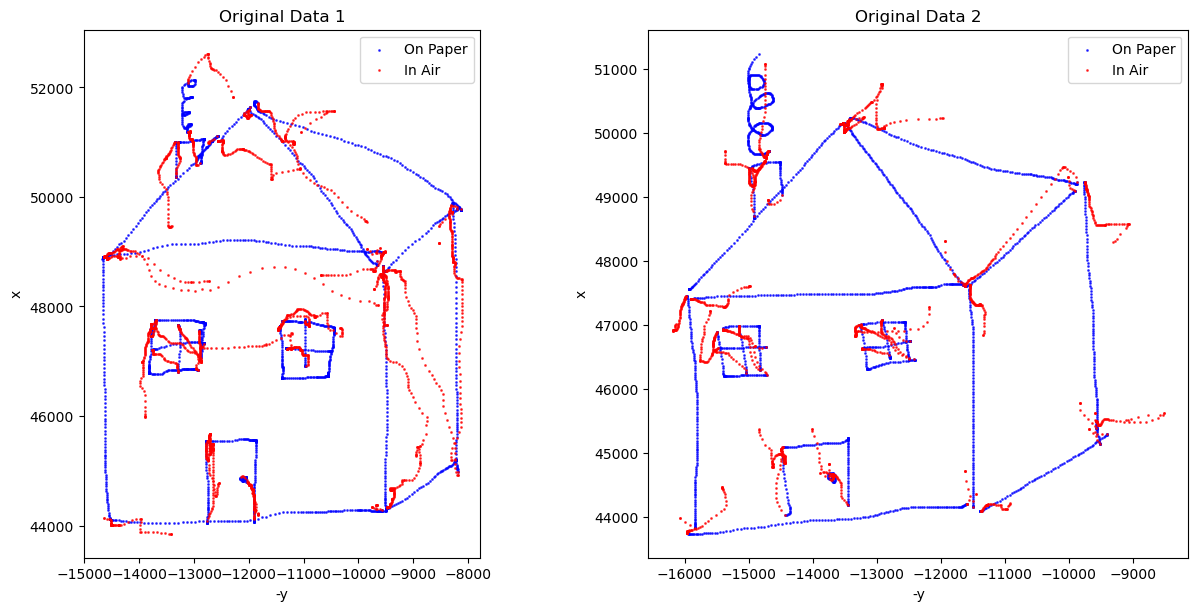

Processed data shape: (7936, 4)
Average number of data points: 3968


In [2]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=2)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [3]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # Changed to 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed to 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)

# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


latent_dim = 128
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [4]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of points
        if num_points < augmented_data.shape[0]:
            augmented_data = augmented_data[:num_points]
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_data = np.vstack([augmented_data, padding])

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status



c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 16/16 [00:41<00:00,  2.62s/batch, Total Loss=0.735, Reconstruction Loss=0.735, KL Loss=0.0068] 


Epoch 1: Total Loss = 0.768312, Reconstruction Loss = 0.768312, KL Divergence Loss = 0.002517
MAE = 0.229068, MSE = 0.076052, NRMSE = 0.275775


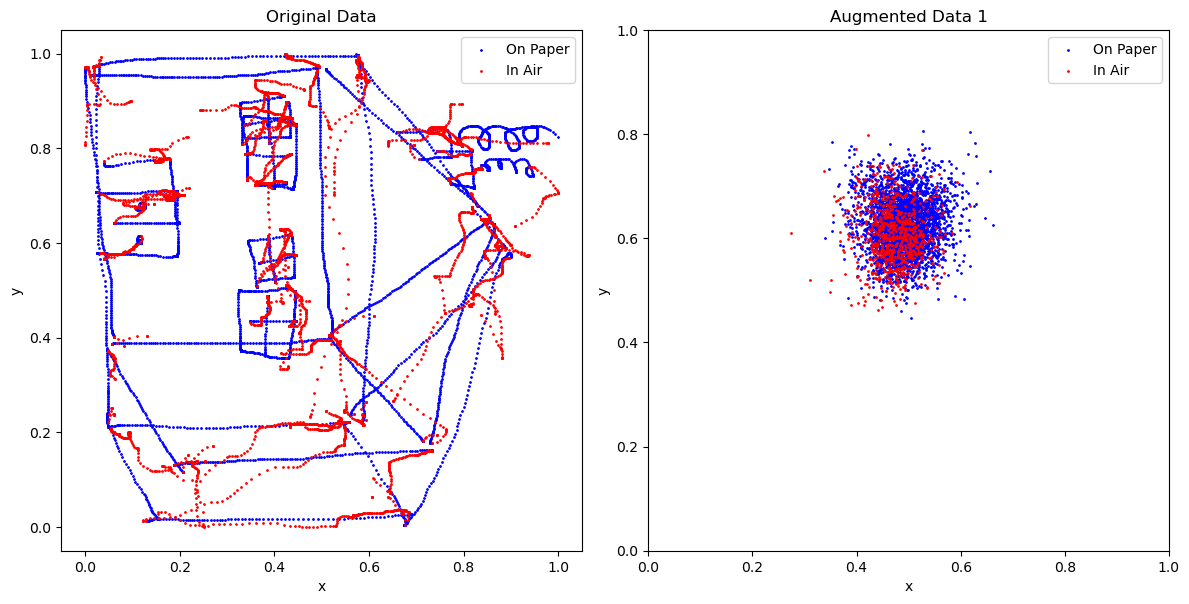

Epoch 2/100: 100%|██████████| 16/16 [00:01<00:00, 11.79batch/s, Total Loss=0.253, Reconstruction Loss=0.253, KL Loss=0.078] 


Epoch 2: Total Loss = 0.552969, Reconstruction Loss = 0.552969, KL Divergence Loss = 0.033254
MAE = 0.231100, MSE = 0.075869, NRMSE = 0.275444


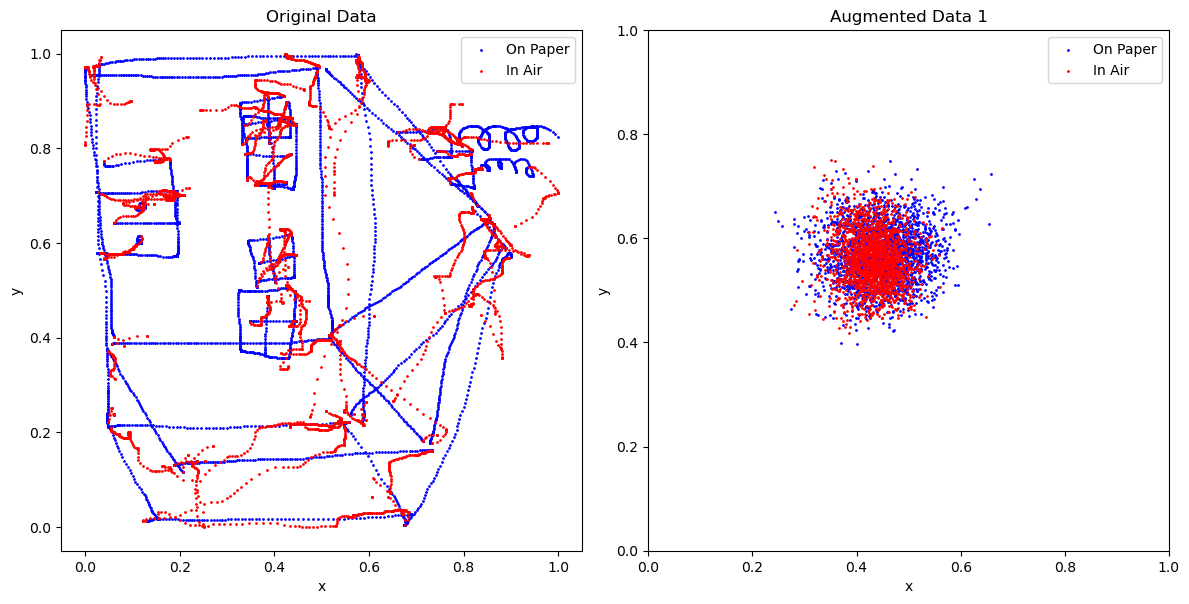

Epoch 3/100: 100%|██████████| 16/16 [00:01<00:00, 12.42batch/s, Total Loss=0.0824, Reconstruction Loss=0.0824, KL Loss=0.294]


Epoch 3: Total Loss = 0.112103, Reconstruction Loss = 0.112102, KL Divergence Loss = 0.184648
MAE = 0.231764, MSE = 0.075589, NRMSE = 0.274934


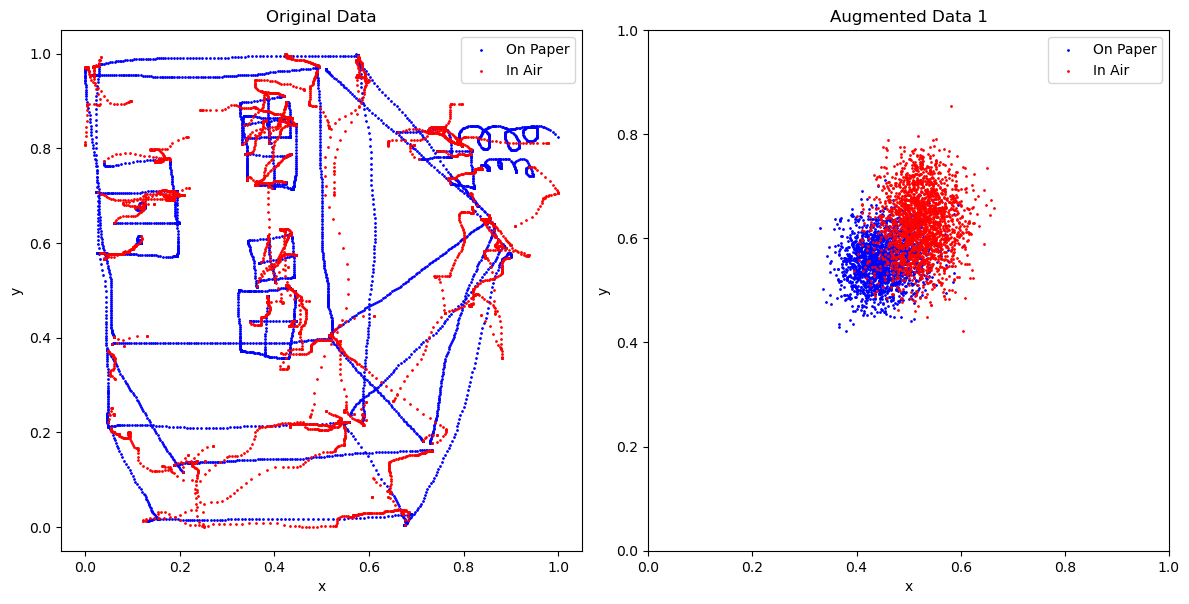

Epoch 4/100: 100%|██████████| 16/16 [00:01<00:00, 11.42batch/s, Total Loss=0.079, Reconstruction Loss=0.079, KL Loss=0.381]  


Epoch 4: Total Loss = 0.080345, Reconstruction Loss = 0.080345, KL Divergence Loss = 0.345284
MAE = 0.235270, MSE = 0.077079, NRMSE = 0.277630


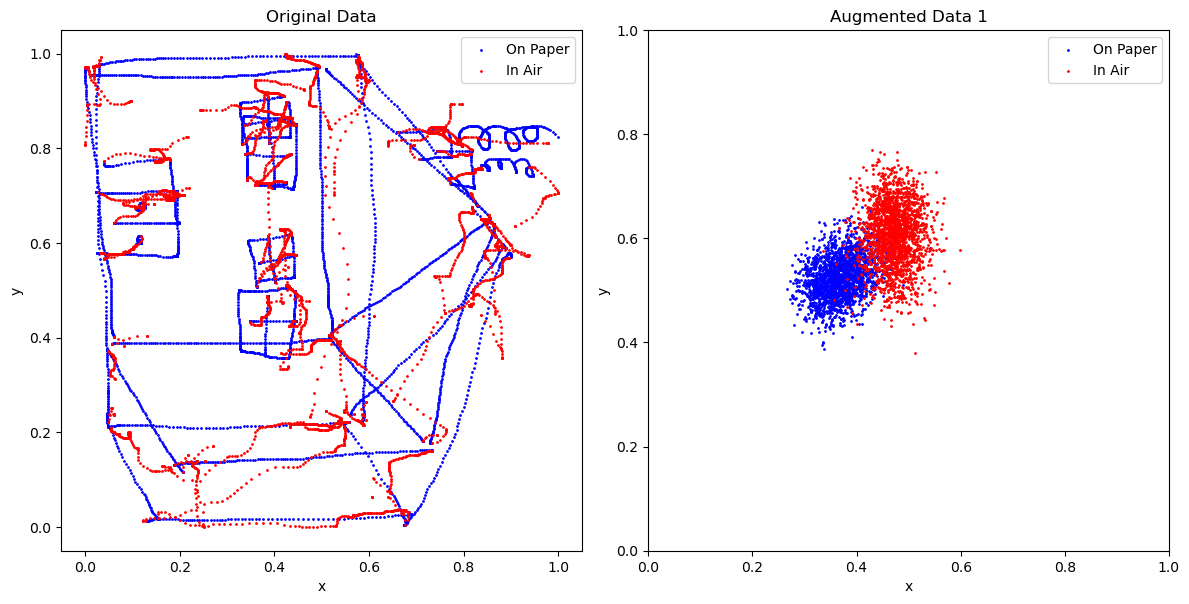

Epoch 5/100: 100%|██████████| 16/16 [00:01<00:00, 13.29batch/s, Total Loss=0.074, Reconstruction Loss=0.074, KL Loss=0.406]  


Epoch 5: Total Loss = 0.076059, Reconstruction Loss = 0.076059, KL Divergence Loss = 0.385494
MAE = 0.238410, MSE = 0.078554, NRMSE = 0.280275


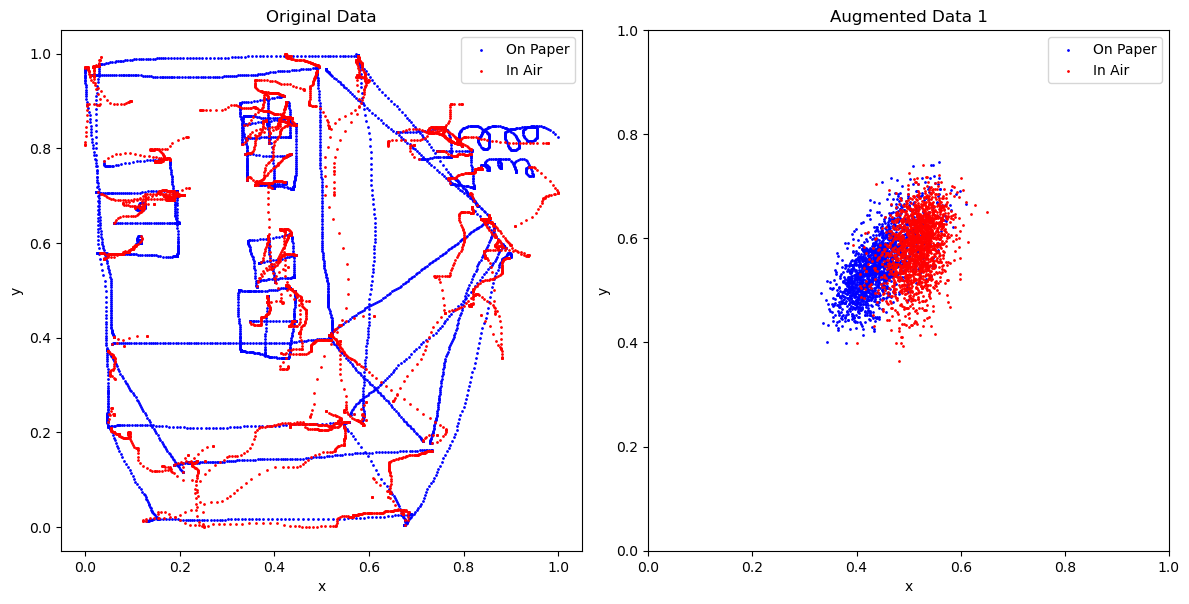

Epoch 6/100: 100%|██████████| 16/16 [00:01<00:00, 10.96batch/s, Total Loss=0.0645, Reconstruction Loss=0.0645, KL Loss=0.494]


Epoch 6: Total Loss = 0.069059, Reconstruction Loss = 0.069058, KL Divergence Loss = 0.442361
MAE = 0.242046, MSE = 0.080728, NRMSE = 0.284127


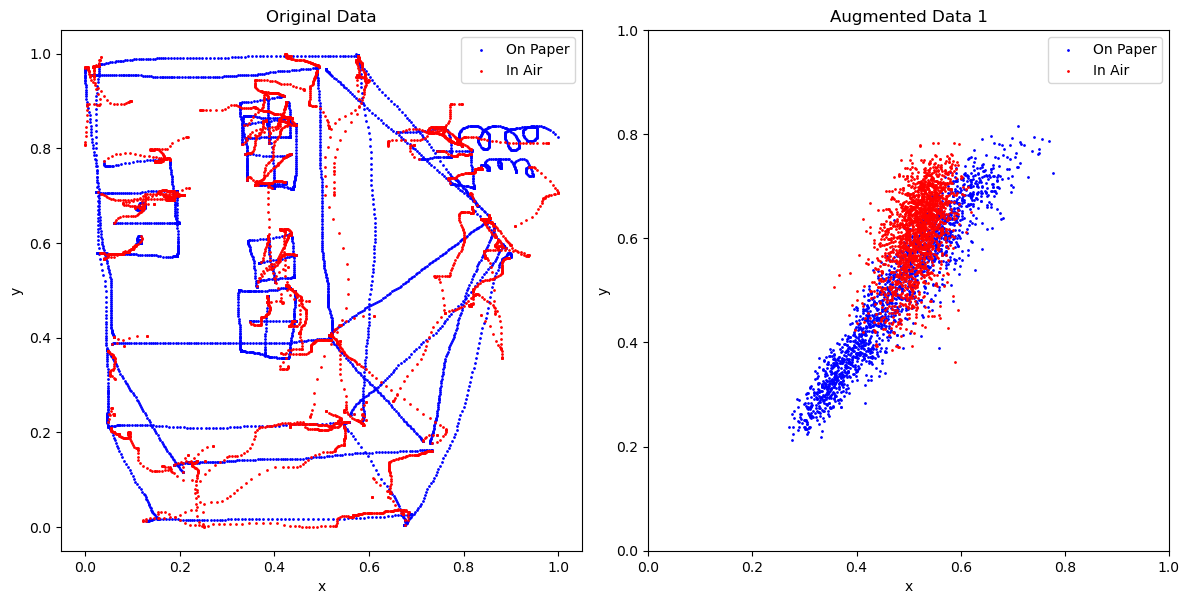

Epoch 7/100: 100%|██████████| 16/16 [00:01<00:00, 15.09batch/s, Total Loss=0.0565, Reconstruction Loss=0.0565, KL Loss=0.763]


Epoch 7: Total Loss = 0.061297, Reconstruction Loss = 0.061296, KL Divergence Loss = 0.624316
MAE = 0.247627, MSE = 0.084910, NRMSE = 0.291394


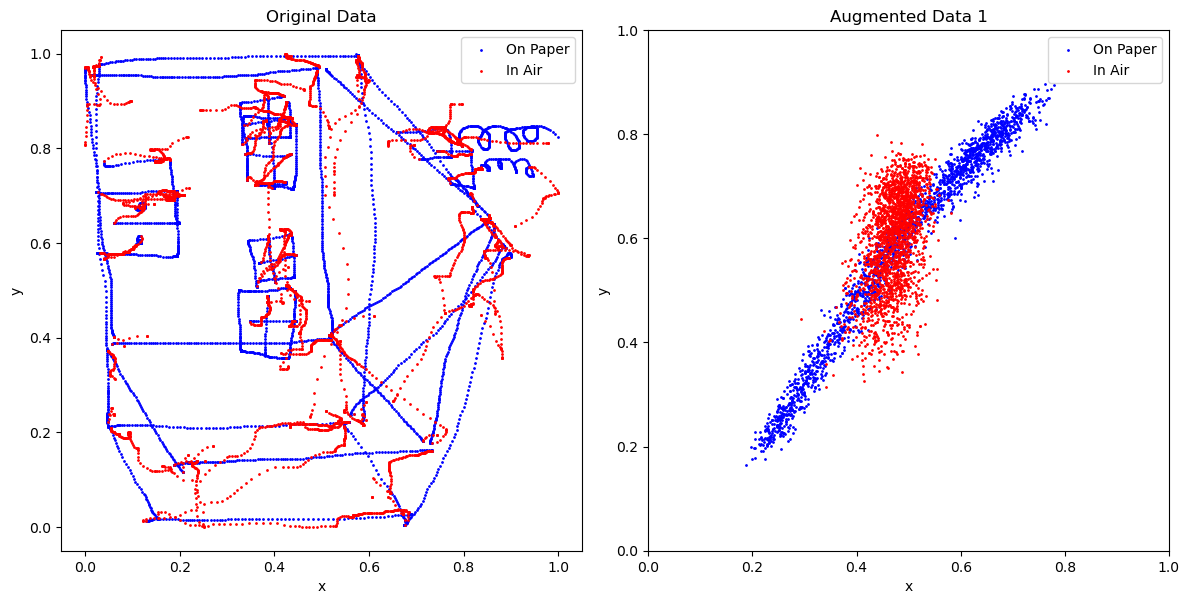

Epoch 8/100: 100%|██████████| 16/16 [00:01<00:00, 11.20batch/s, Total Loss=0.057, Reconstruction Loss=0.057, KL Loss=0.9]    


Epoch 8: Total Loss = 0.055903, Reconstruction Loss = 0.055902, KL Divergence Loss = 0.838593
MAE = 0.258646, MSE = 0.093389, NRMSE = 0.305596


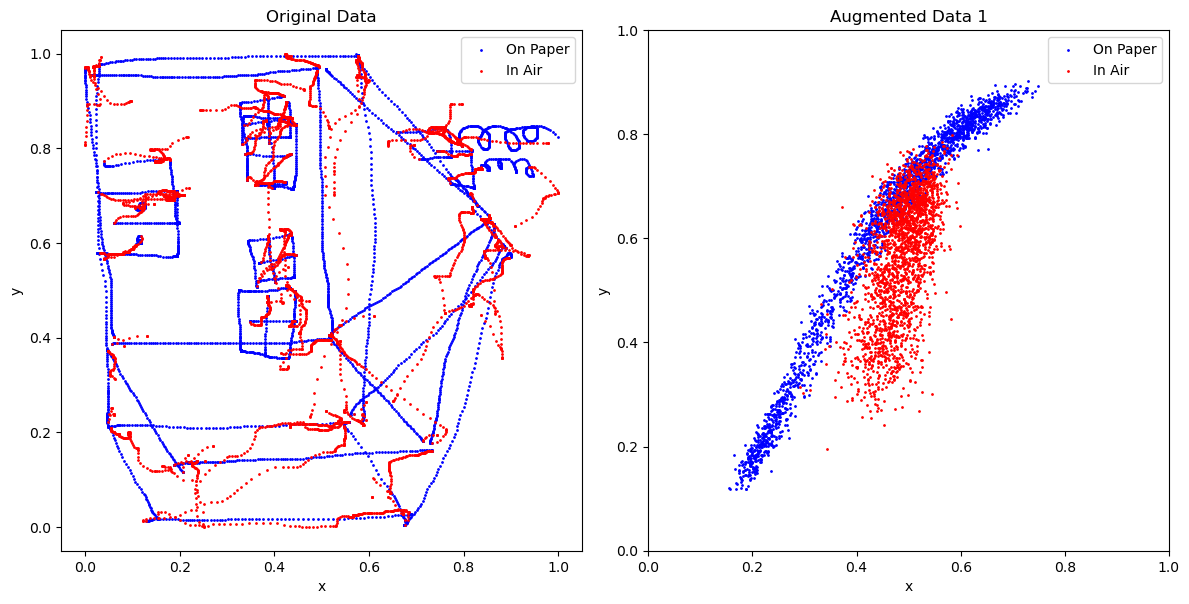

Epoch 9/100: 100%|██████████| 16/16 [00:00<00:00, 16.64batch/s, Total Loss=0.0478, Reconstruction Loss=0.0478, KL Loss=1.03] 


Epoch 9: Total Loss = 0.049837, Reconstruction Loss = 0.049836, KL Divergence Loss = 0.958684
MAE = 0.267553, MSE = 0.100506, NRMSE = 0.317027


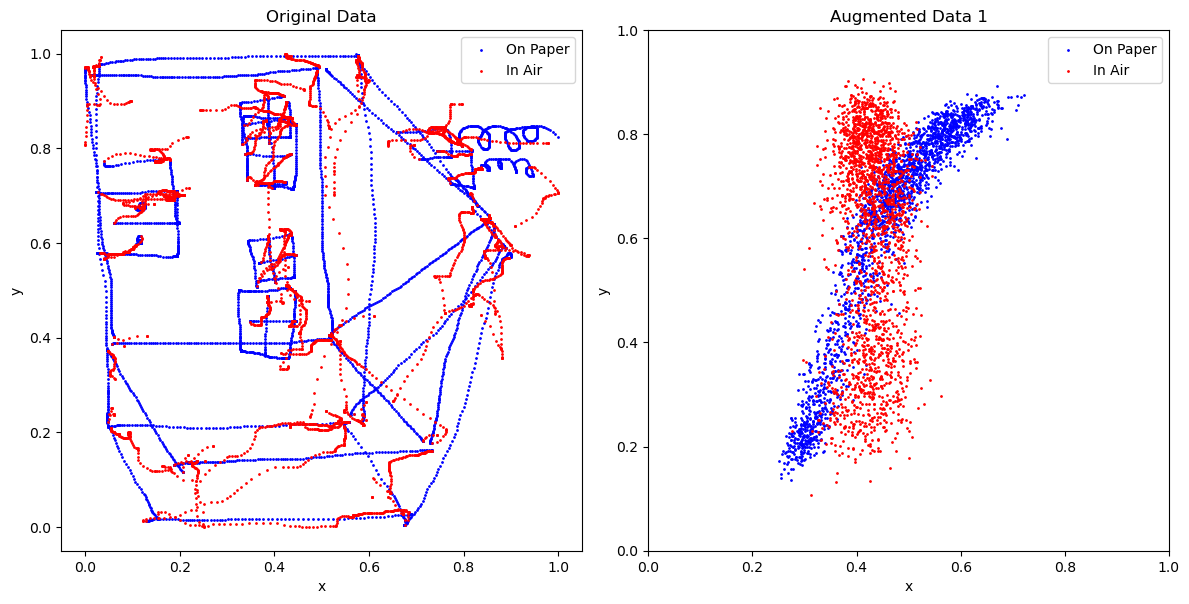

Epoch 10/100: 100%|██████████| 16/16 [00:01<00:00, 14.92batch/s, Total Loss=0.0356, Reconstruction Loss=0.0356, KL Loss=1.17]


Epoch 10: Total Loss = 0.041576, Reconstruction Loss = 0.041575, KL Divergence Loss = 1.110765
MAE = 0.273791, MSE = 0.105895, NRMSE = 0.325415


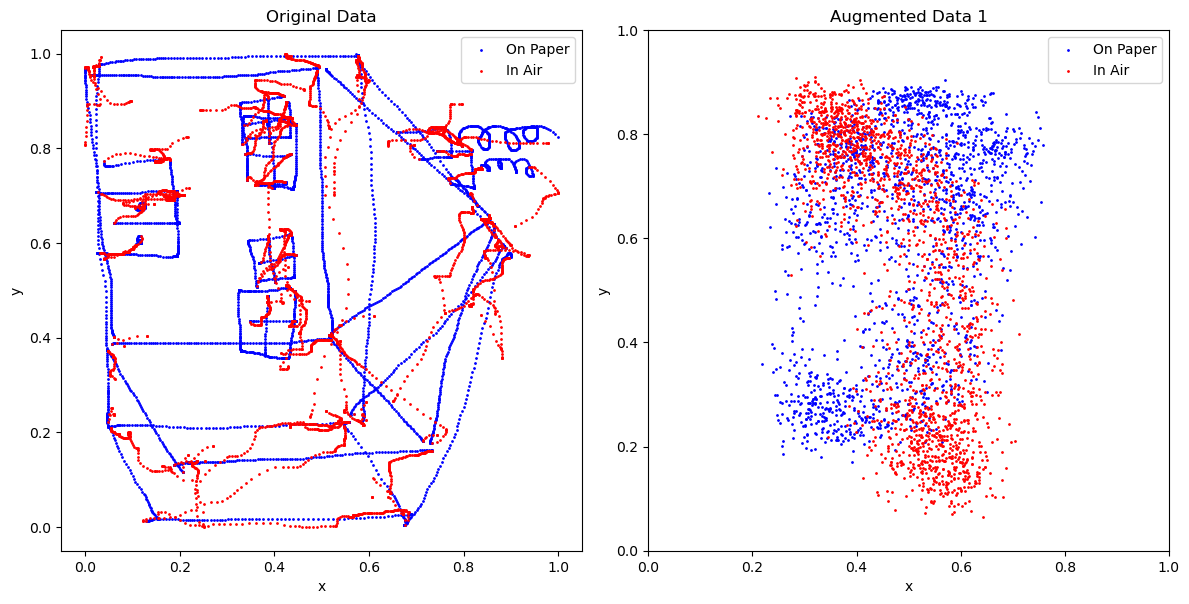

Epoch 11/100: 100%|██████████| 16/16 [00:00<00:00, 19.39batch/s, Total Loss=0.0249, Reconstruction Loss=0.0249, KL Loss=1.44]


Epoch 11: Total Loss = 0.028894, Reconstruction Loss = 0.028893, KL Divergence Loss = 1.352403
MAE = 0.273863, MSE = 0.105424, NRMSE = 0.324690


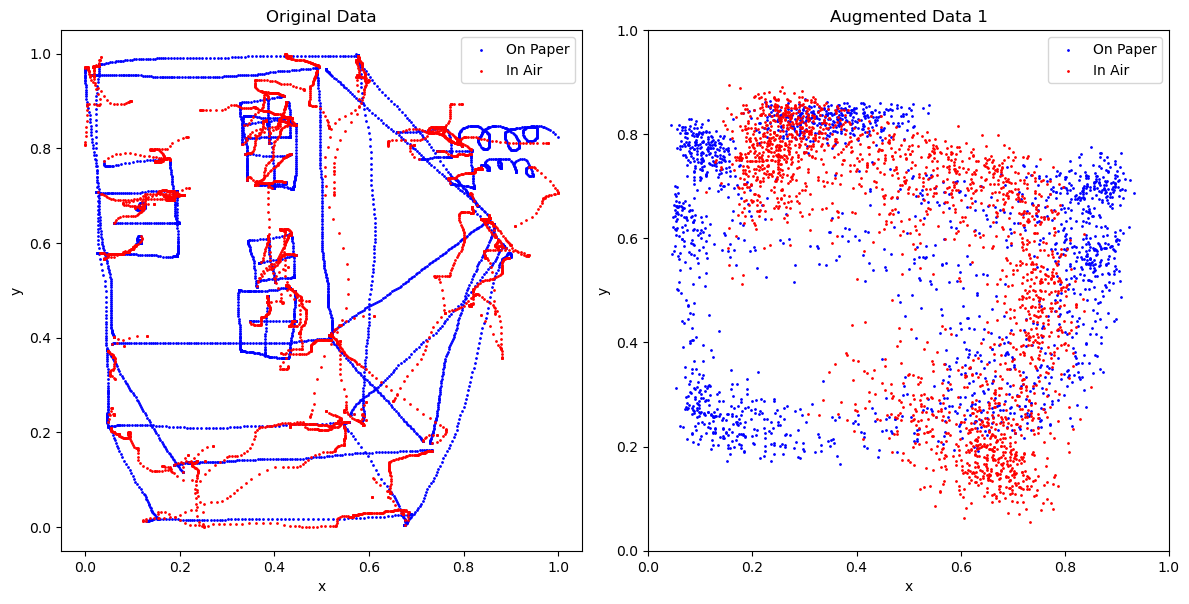

Epoch 12/100: 100%|██████████| 16/16 [00:00<00:00, 21.71batch/s, Total Loss=0.0181, Reconstruction Loss=0.0181, KL Loss=1.86]


Epoch 12: Total Loss = 0.021427, Reconstruction Loss = 0.021425, KL Divergence Loss = 1.674748
MAE = 0.279133, MSE = 0.109299, NRMSE = 0.330604


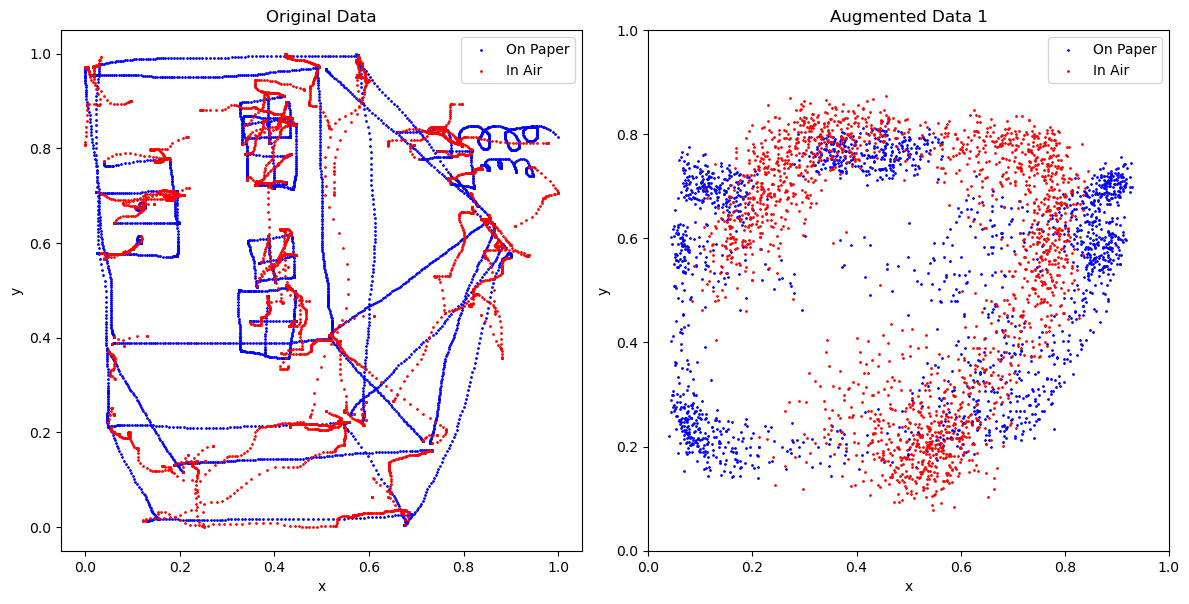

Epoch 13/100: 100%|██████████| 16/16 [00:01<00:00, 14.68batch/s, Total Loss=0.0133, Reconstruction Loss=0.0133, KL Loss=2.18]


Epoch 13: Total Loss = 0.016441, Reconstruction Loss = 0.016439, KL Divergence Loss = 1.998718
MAE = 0.281693, MSE = 0.111659, NRMSE = 0.334154


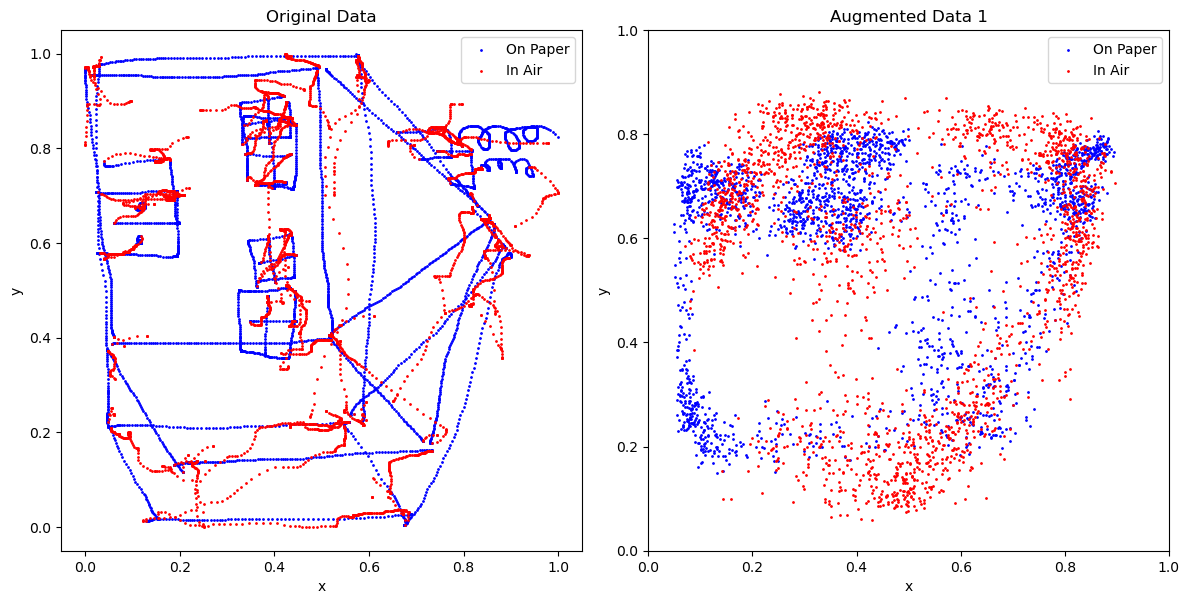

Epoch 14/100: 100%|██████████| 16/16 [00:00<00:00, 17.25batch/s, Total Loss=0.00668, Reconstruction Loss=0.00667, KL Loss=2.61]


Epoch 14: Total Loss = 0.010349, Reconstruction Loss = 0.010347, KL Divergence Loss = 2.366785
MAE = 0.282972, MSE = 0.113098, NRMSE = 0.336300


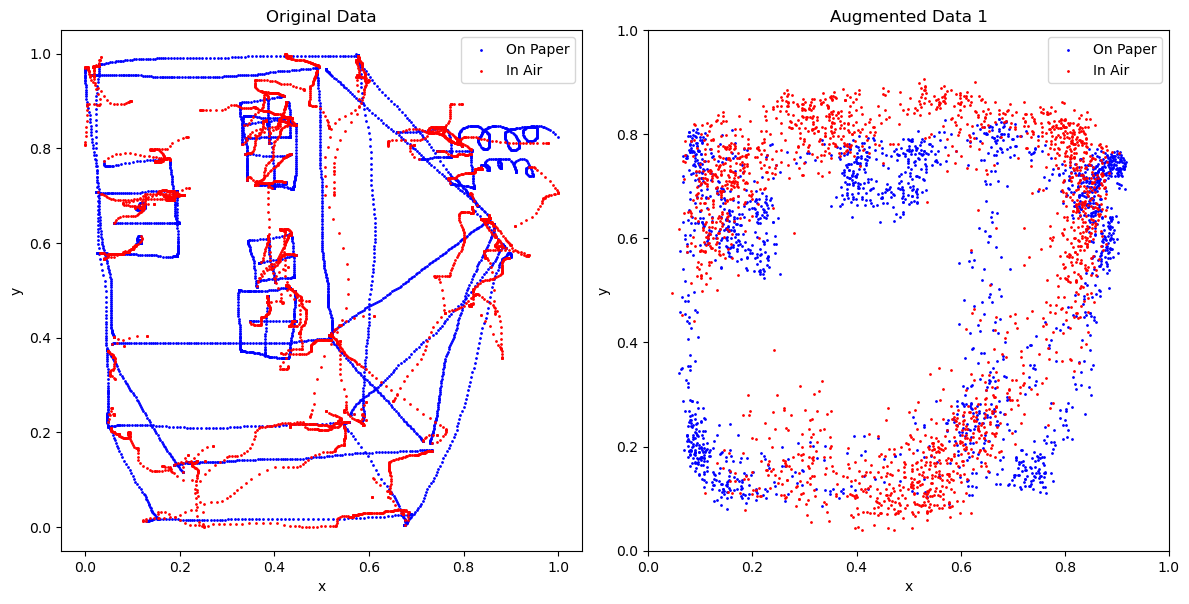

Epoch 15/100: 100%|██████████| 16/16 [00:00<00:00, 19.05batch/s, Total Loss=0.00296, Reconstruction Loss=0.00296, KL Loss=2.88]


Epoch 15: Total Loss = 0.004504, Reconstruction Loss = 0.004502, KL Divergence Loss = 2.743804
MAE = 0.282183, MSE = 0.112057, NRMSE = 0.334749


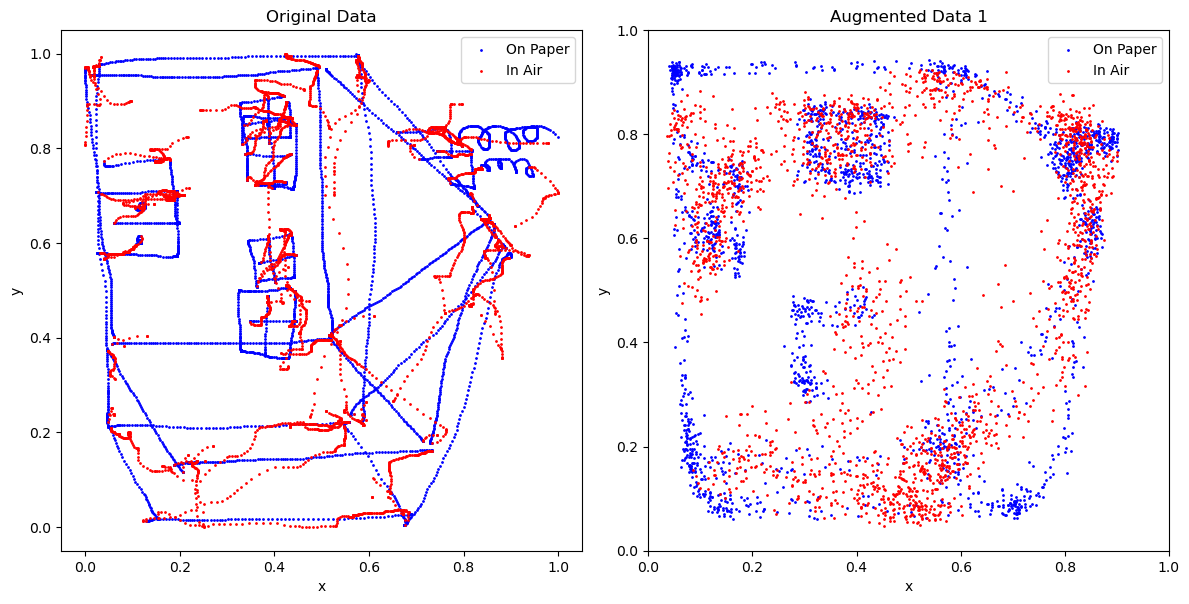

Epoch 16/100: 100%|██████████| 16/16 [00:00<00:00, 20.32batch/s, Total Loss=0.00228, Reconstruction Loss=0.00228, KL Loss=3.33]


Epoch 16: Total Loss = 0.002748, Reconstruction Loss = 0.002745, KL Divergence Loss = 3.094226
MAE = 0.278624, MSE = 0.108883, NRMSE = 0.329974


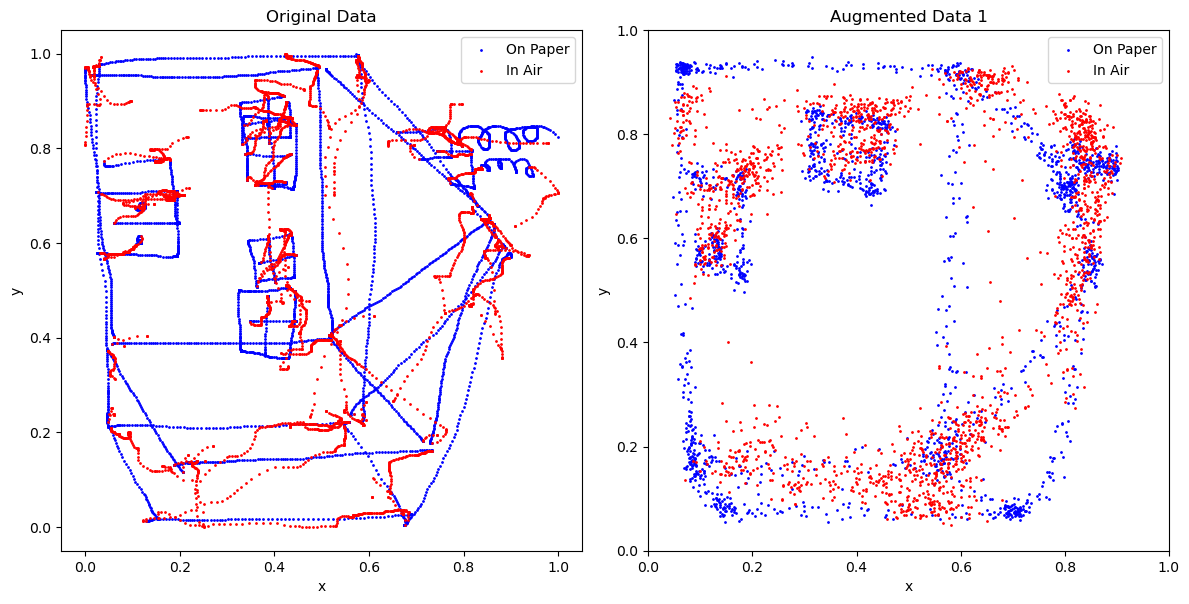

Epoch 17/100: 100%|██████████| 16/16 [00:00<00:00, 23.75batch/s, Total Loss=0.00184, Reconstruction Loss=0.00184, KL Loss=3.43]


Epoch 17: Total Loss = 0.002146, Reconstruction Loss = 0.002143, KL Divergence Loss = 3.406720
MAE = 0.279008, MSE = 0.109552, NRMSE = 0.330987


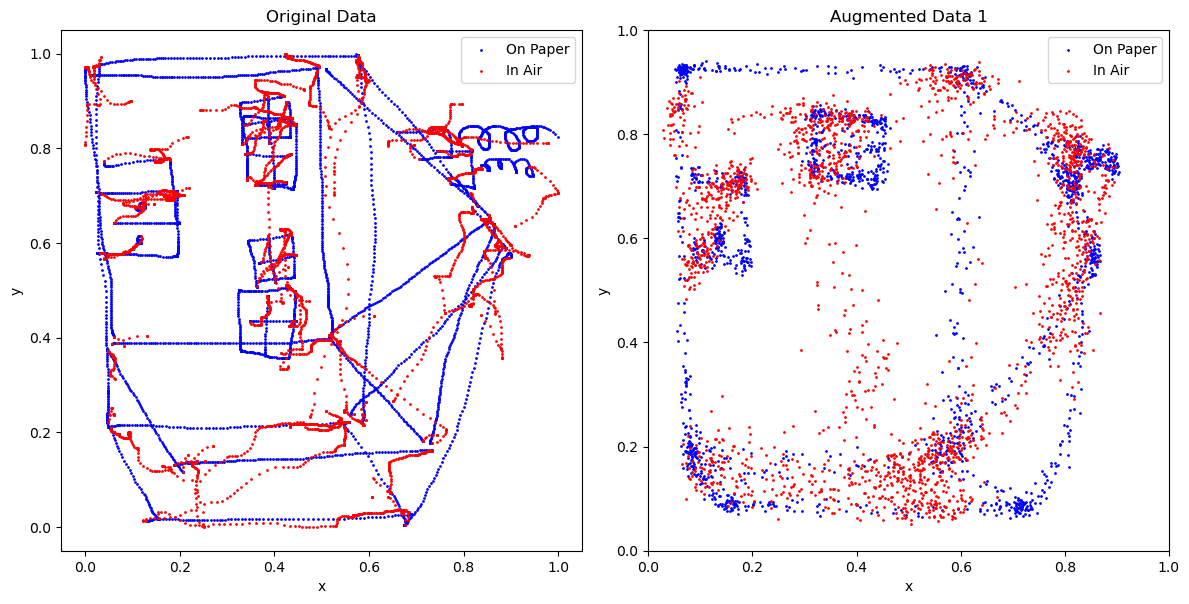

Epoch 18/100: 100%|██████████| 16/16 [00:00<00:00, 19.33batch/s, Total Loss=0.00158, Reconstruction Loss=0.00158, KL Loss=3.64]


Epoch 18: Total Loss = 0.001629, Reconstruction Loss = 0.001625, KL Divergence Loss = 3.656339
MAE = 0.277086, MSE = 0.108084, NRMSE = 0.328761


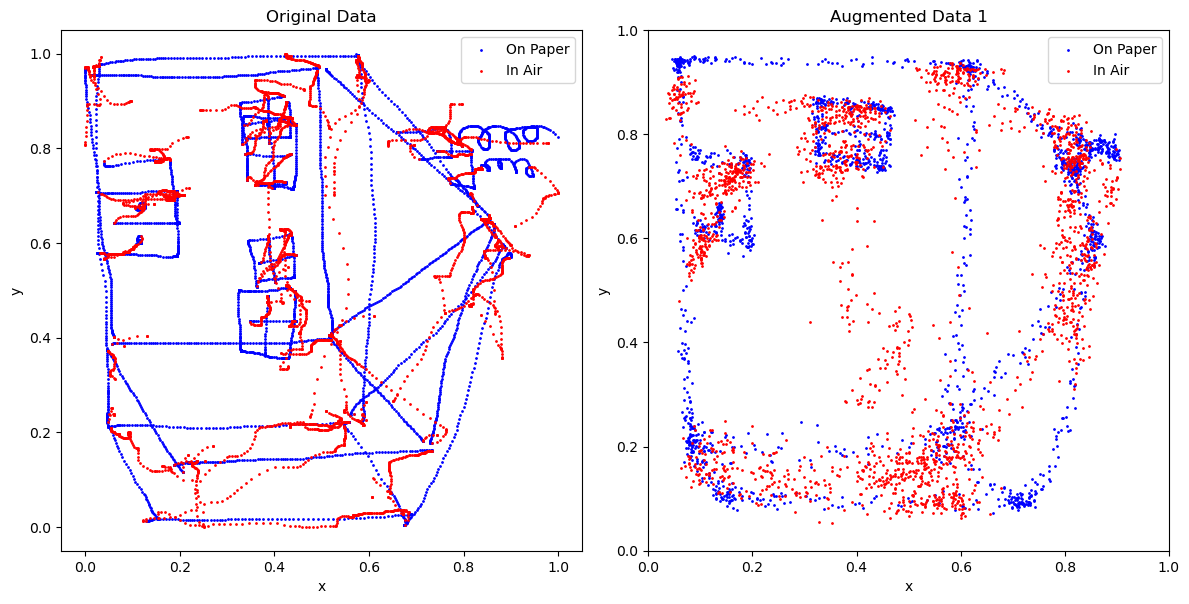

Epoch 19/100: 100%|██████████| 16/16 [00:00<00:00, 18.81batch/s, Total Loss=0.00119, Reconstruction Loss=0.00119, KL Loss=4.04]


Epoch 19: Total Loss = 0.001266, Reconstruction Loss = 0.001262, KL Divergence Loss = 3.884828
MAE = 0.276830, MSE = 0.108051, NRMSE = 0.328711


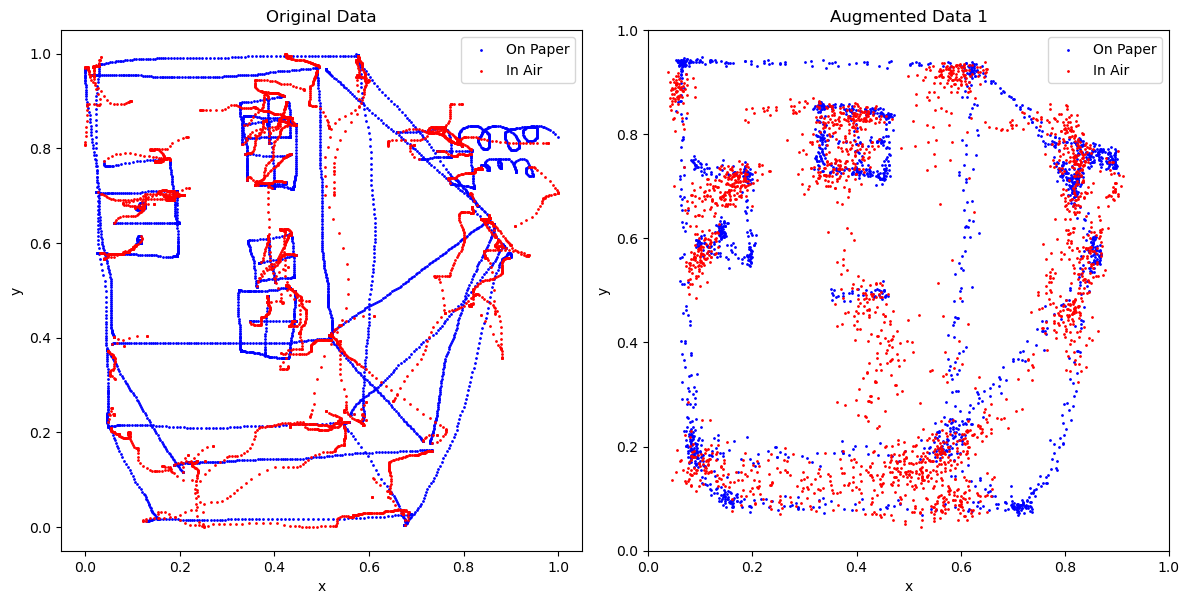

Epoch 20/100: 100%|██████████| 16/16 [00:00<00:00, 18.15batch/s, Total Loss=0.00115, Reconstruction Loss=0.00114, KL Loss=4.11]


Epoch 20: Total Loss = 0.001180, Reconstruction Loss = 0.001176, KL Divergence Loss = 4.077567
MAE = 0.276150, MSE = 0.107273, NRMSE = 0.327525


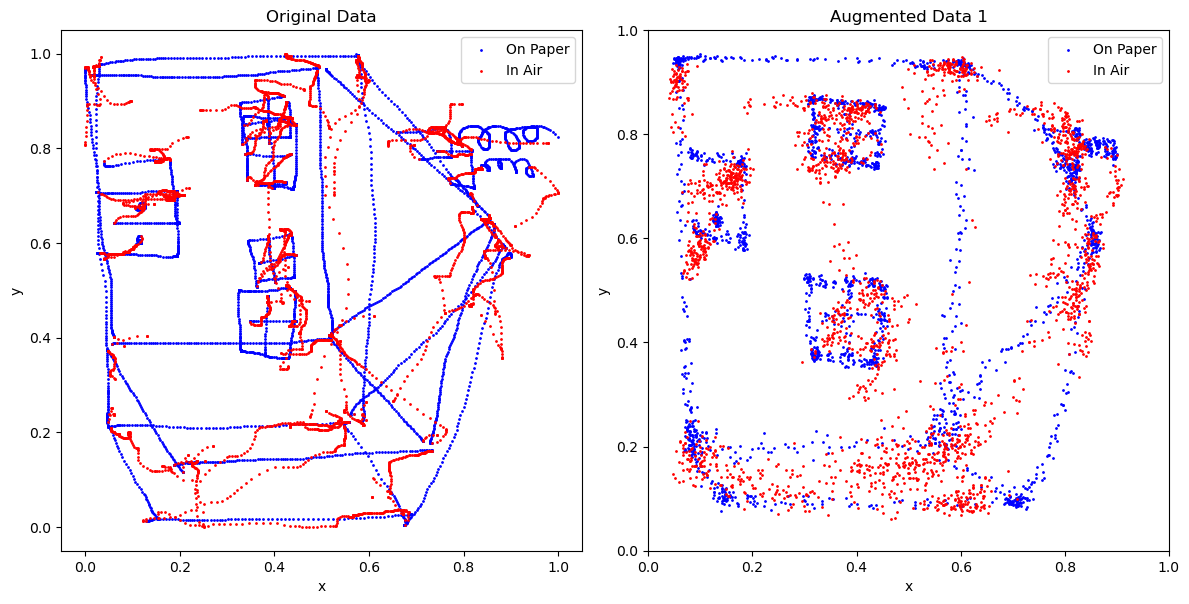

Epoch 21/100: 100%|██████████| 16/16 [00:01<00:00, 12.68batch/s, Total Loss=0.00104, Reconstruction Loss=0.00103, KL Loss=4.2]   


Epoch 21: Total Loss = 0.001166, Reconstruction Loss = 0.001161, KL Divergence Loss = 4.235729
MAE = 0.275537, MSE = 0.107309, NRMSE = 0.327580


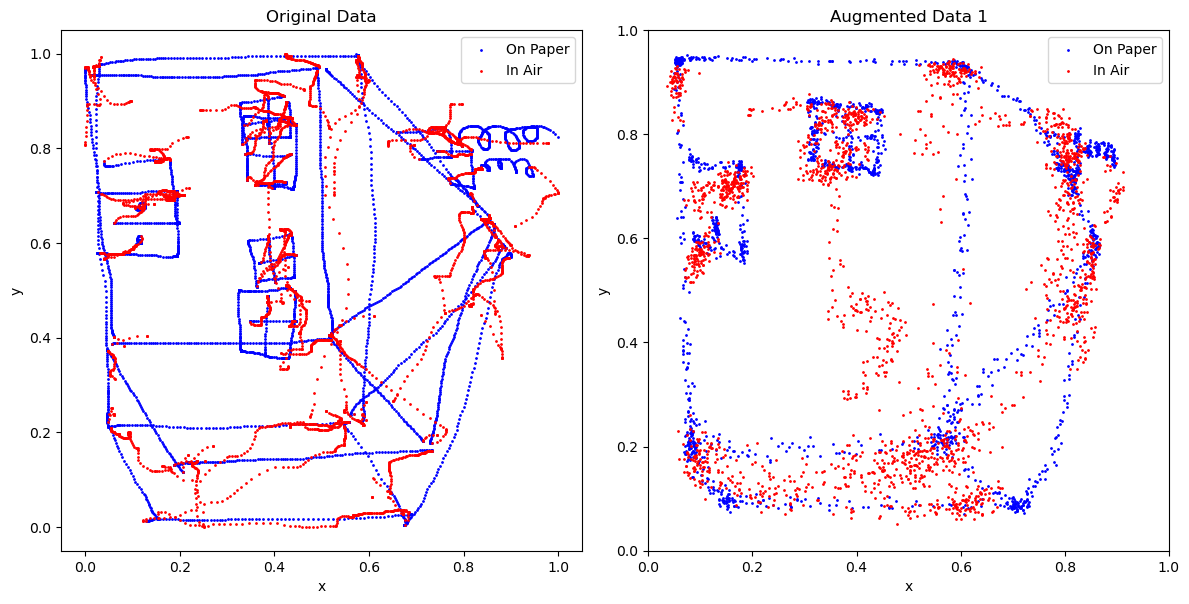

Epoch 22/100: 100%|██████████| 16/16 [00:00<00:00, 17.68batch/s, Total Loss=0.000927, Reconstruction Loss=0.000922, KL Loss=4.52]


Epoch 22: Total Loss = 0.000949, Reconstruction Loss = 0.000944, KL Divergence Loss = 4.375265
MAE = 0.275777, MSE = 0.106777, NRMSE = 0.326767


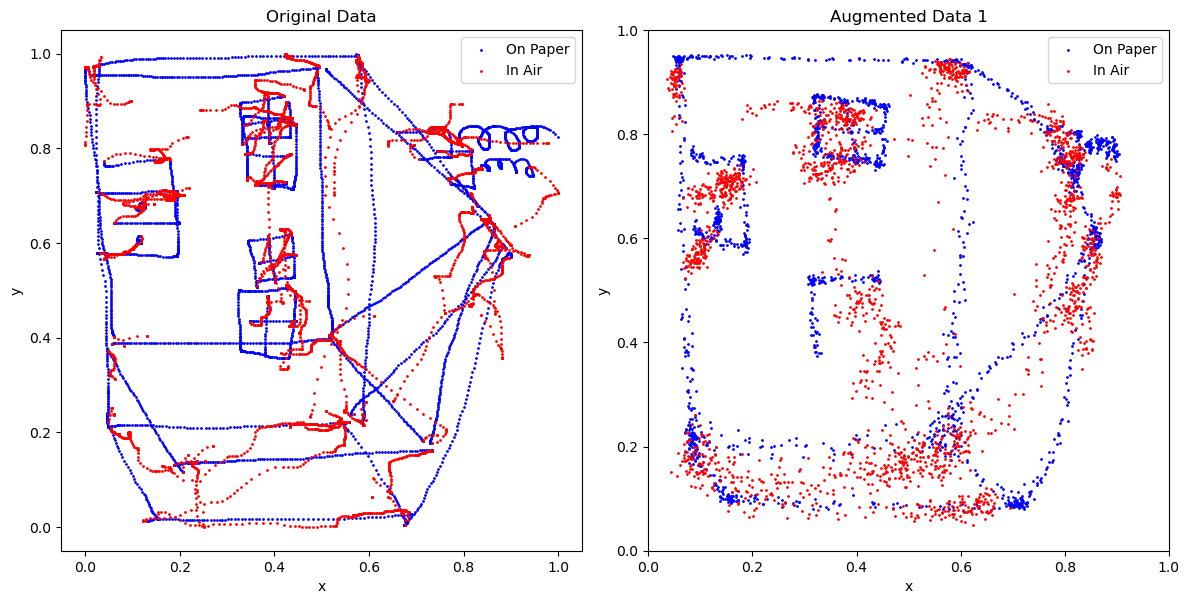

Epoch 23/100: 100%|██████████| 16/16 [00:01<00:00, 15.11batch/s, Total Loss=0.00113, Reconstruction Loss=0.00113, KL Loss=4.43]


Epoch 23: Total Loss = 0.001098, Reconstruction Loss = 0.001093, KL Divergence Loss = 4.488240
MAE = 0.276561, MSE = 0.107517, NRMSE = 0.327898


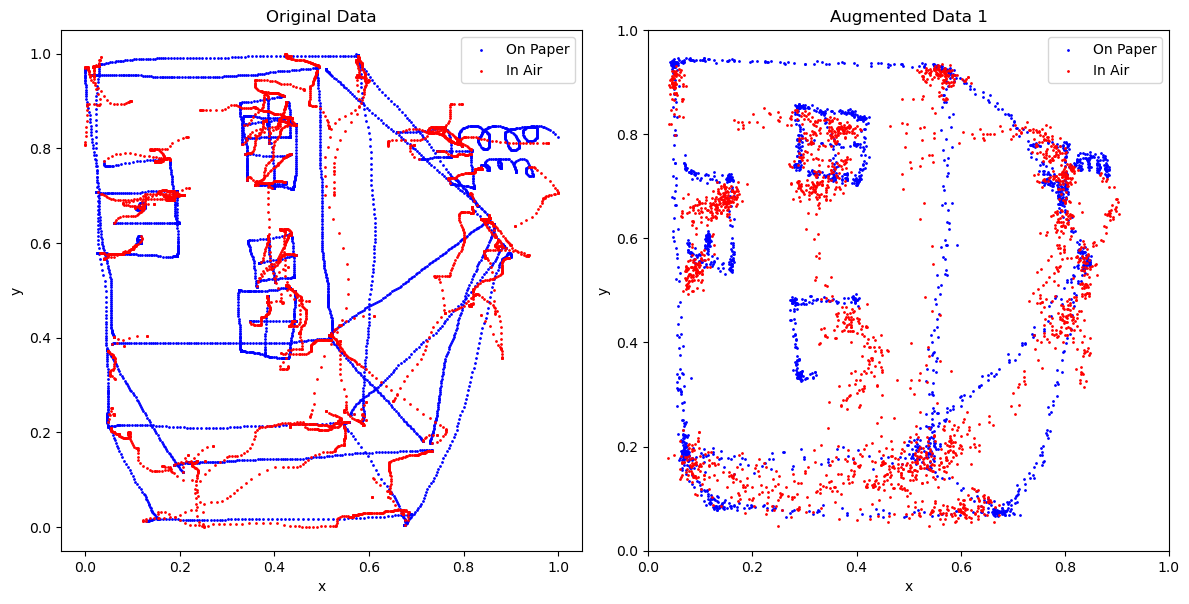

Epoch 24/100: 100%|██████████| 16/16 [00:00<00:00, 23.73batch/s, Total Loss=0.000929, Reconstruction Loss=0.000924, KL Loss=4.55]


Epoch 24: Total Loss = 0.001050, Reconstruction Loss = 0.001045, KL Divergence Loss = 4.578759
MAE = 0.274847, MSE = 0.106411, NRMSE = 0.326207


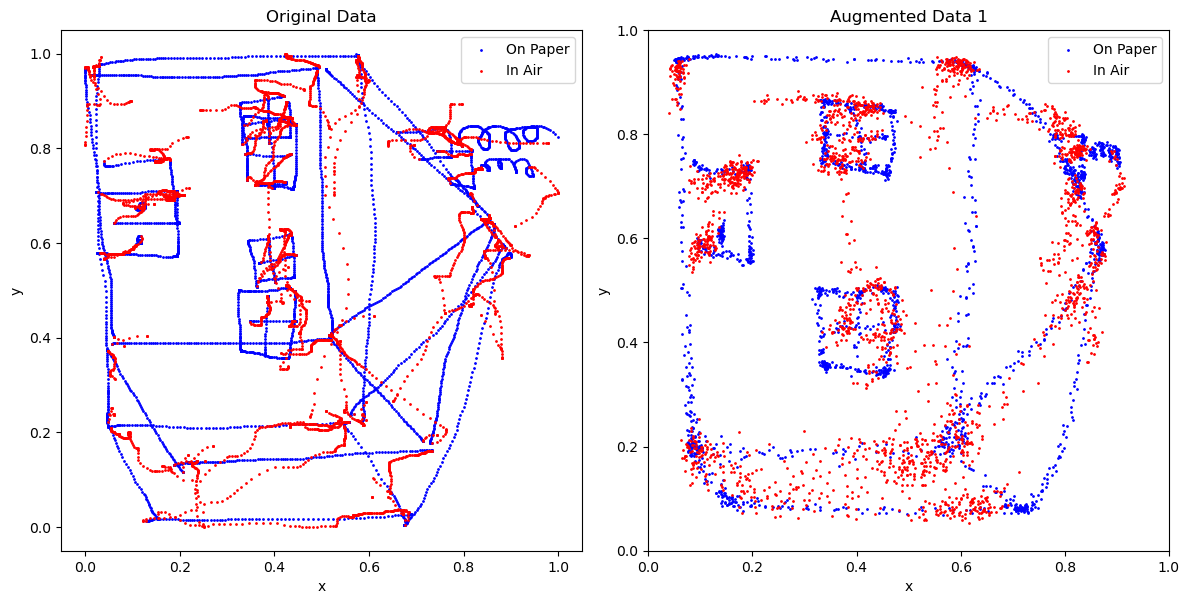

Epoch 25/100: 100%|██████████| 16/16 [00:00<00:00, 16.75batch/s, Total Loss=0.000654, Reconstruction Loss=0.000649, KL Loss=4.91]


Epoch 25: Total Loss = 0.000788, Reconstruction Loss = 0.000784, KL Divergence Loss = 4.664652
MAE = 0.275391, MSE = 0.106936, NRMSE = 0.327011


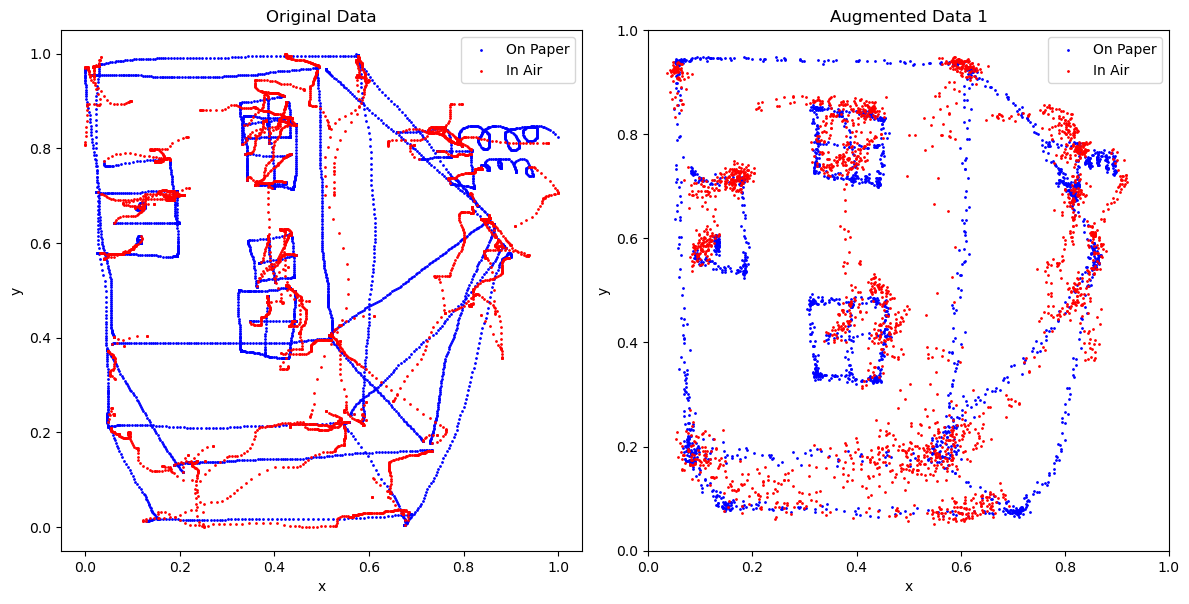

Epoch 26/100: 100%|██████████| 16/16 [00:00<00:00, 19.47batch/s, Total Loss=0.000694, Reconstruction Loss=0.000689, KL Loss=4.88]


Epoch 26: Total Loss = 0.000715, Reconstruction Loss = 0.000710, KL Divergence Loss = 4.758063
MAE = 0.275137, MSE = 0.106483, NRMSE = 0.326318


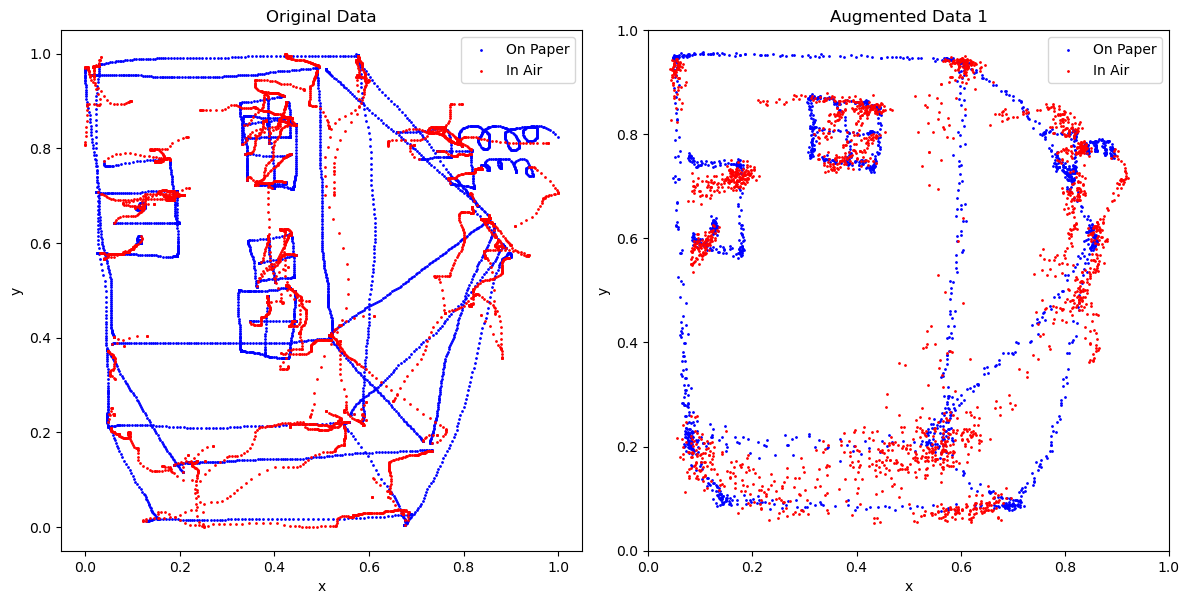

Epoch 27/100: 100%|██████████| 16/16 [00:00<00:00, 19.23batch/s, Total Loss=0.000703, Reconstruction Loss=0.000698, KL Loss=4.89]


Epoch 27: Total Loss = 0.000694, Reconstruction Loss = 0.000689, KL Divergence Loss = 4.850089
MAE = 0.273868, MSE = 0.105852, NRMSE = 0.325348


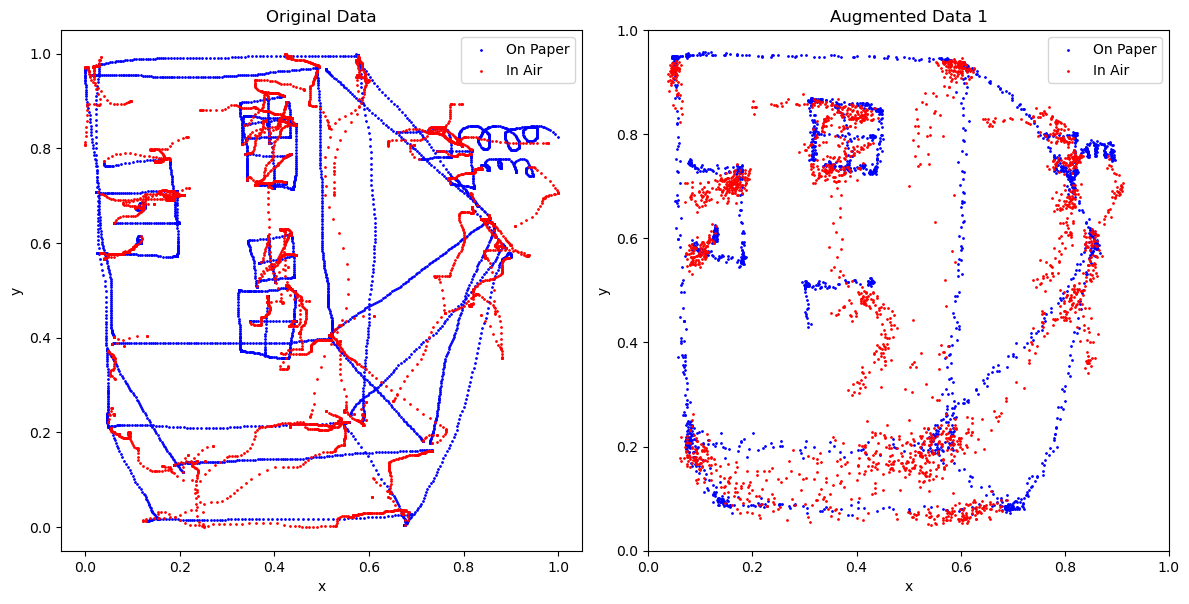

Epoch 28/100: 100%|██████████| 16/16 [00:00<00:00, 18.08batch/s, Total Loss=0.000789, Reconstruction Loss=0.000784, KL Loss=4.91]


Epoch 28: Total Loss = 0.000707, Reconstruction Loss = 0.000702, KL Divergence Loss = 4.937462
MAE = 0.275905, MSE = 0.107302, NRMSE = 0.327570


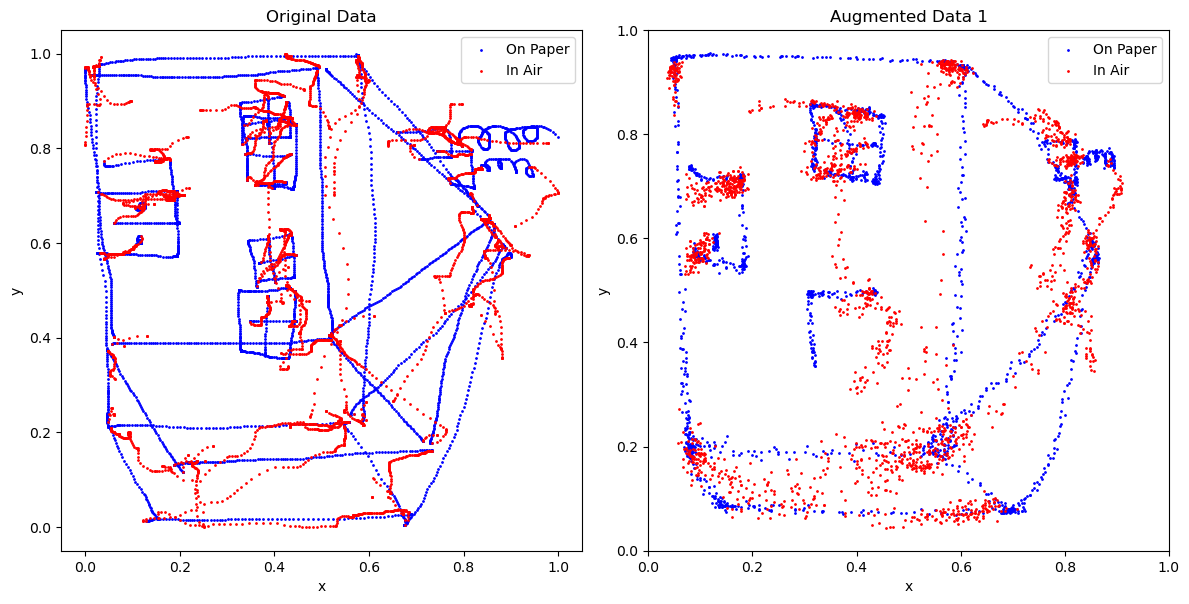

Epoch 29/100: 100%|██████████| 16/16 [00:00<00:00, 17.62batch/s, Total Loss=0.000693, Reconstruction Loss=0.000688, KL Loss=5.01]


Epoch 29: Total Loss = 0.000745, Reconstruction Loss = 0.000740, KL Divergence Loss = 5.011775
MAE = 0.275189, MSE = 0.106871, NRMSE = 0.326911


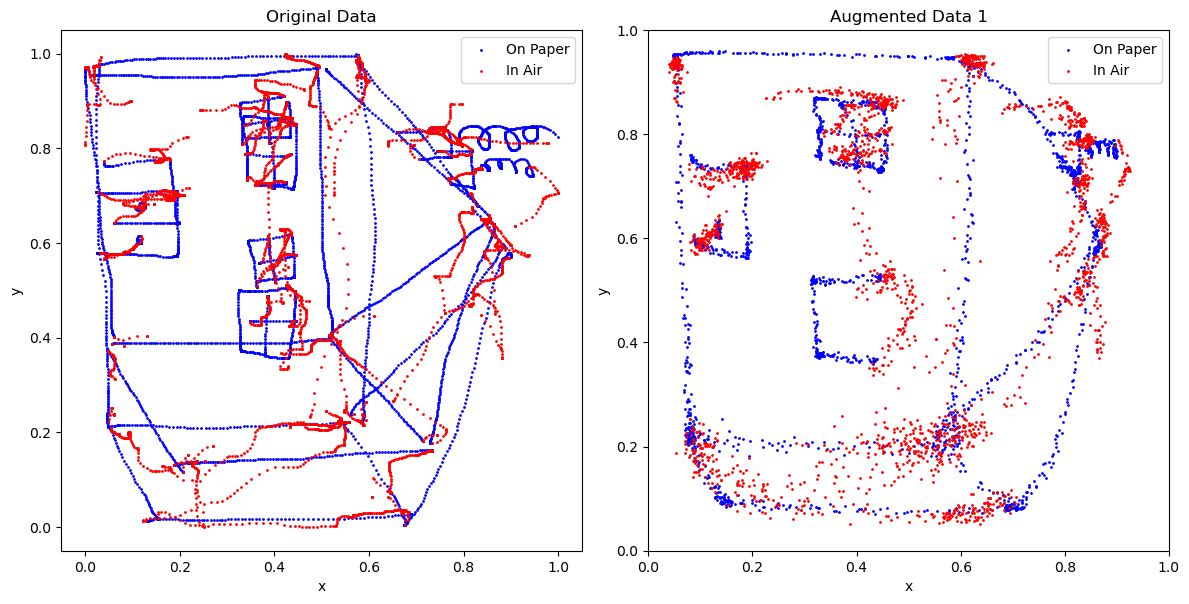

Epoch 30/100: 100%|██████████| 16/16 [00:00<00:00, 22.20batch/s, Total Loss=0.000649, Reconstruction Loss=0.000644, KL Loss=5.04]


Epoch 30: Total Loss = 0.000687, Reconstruction Loss = 0.000682, KL Divergence Loss = 5.079449
MAE = 0.275517, MSE = 0.106705, NRMSE = 0.326658


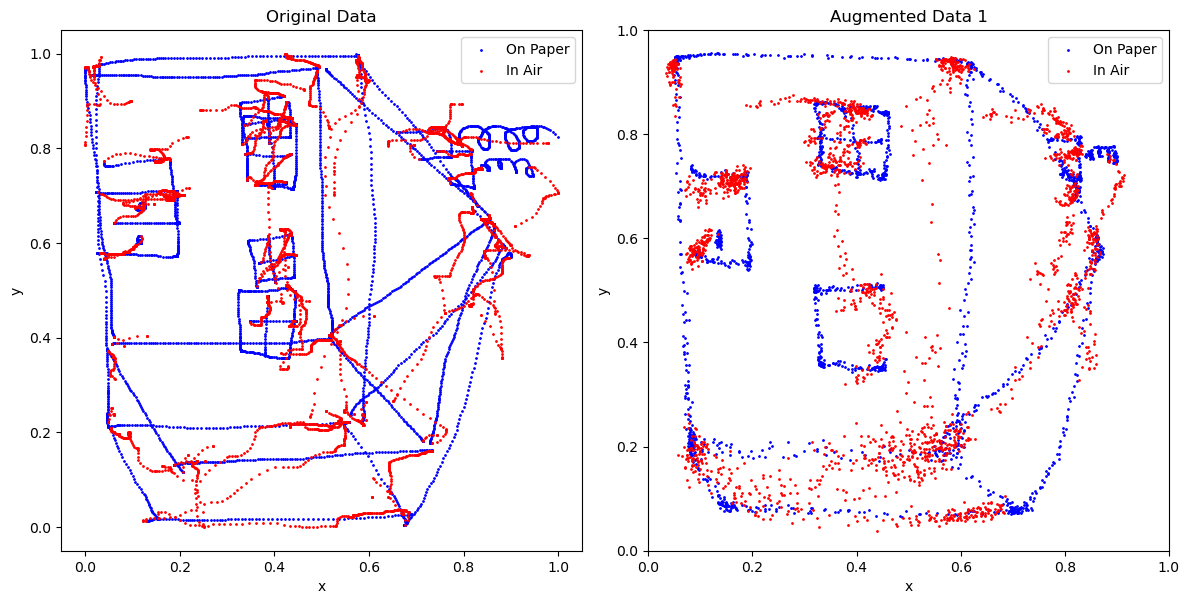

Epoch 31/100: 100%|██████████| 16/16 [00:00<00:00, 22.26batch/s, Total Loss=0.000552, Reconstruction Loss=0.000547, KL Loss=4.99]


Epoch 31: Total Loss = 0.000667, Reconstruction Loss = 0.000662, KL Divergence Loss = 5.141241
MAE = 0.275879, MSE = 0.107034, NRMSE = 0.327160


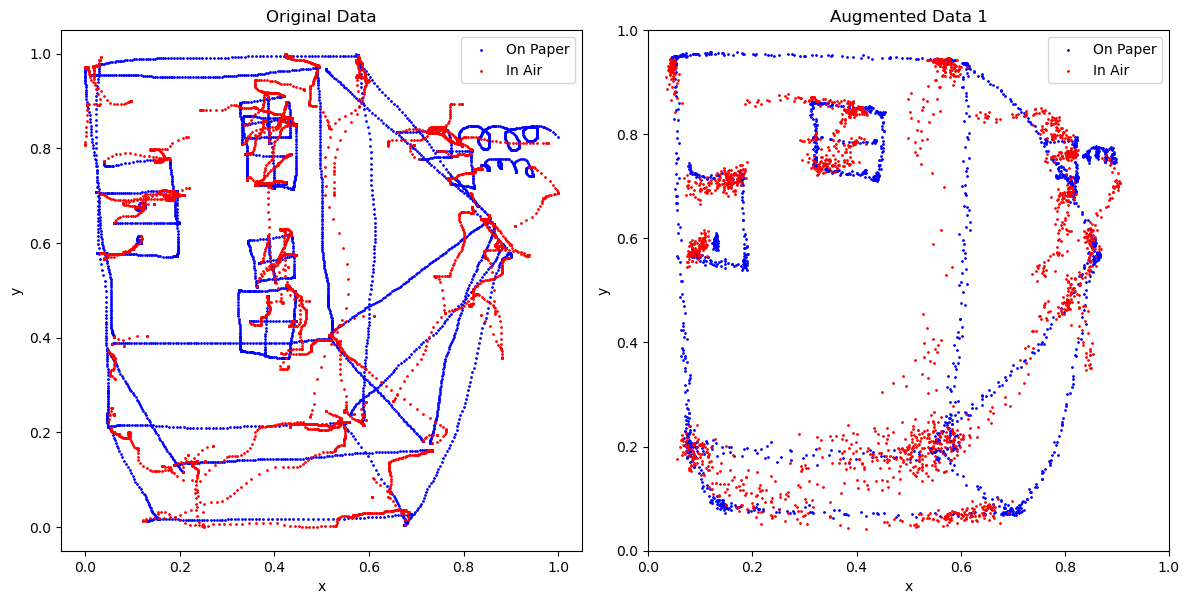

Epoch 32/100: 100%|██████████| 16/16 [00:00<00:00, 18.76batch/s, Total Loss=0.000531, Reconstruction Loss=0.000526, KL Loss=5.24]


Epoch 32: Total Loss = 0.000591, Reconstruction Loss = 0.000586, KL Divergence Loss = 5.212818
MAE = 0.274248, MSE = 0.106247, NRMSE = 0.325955


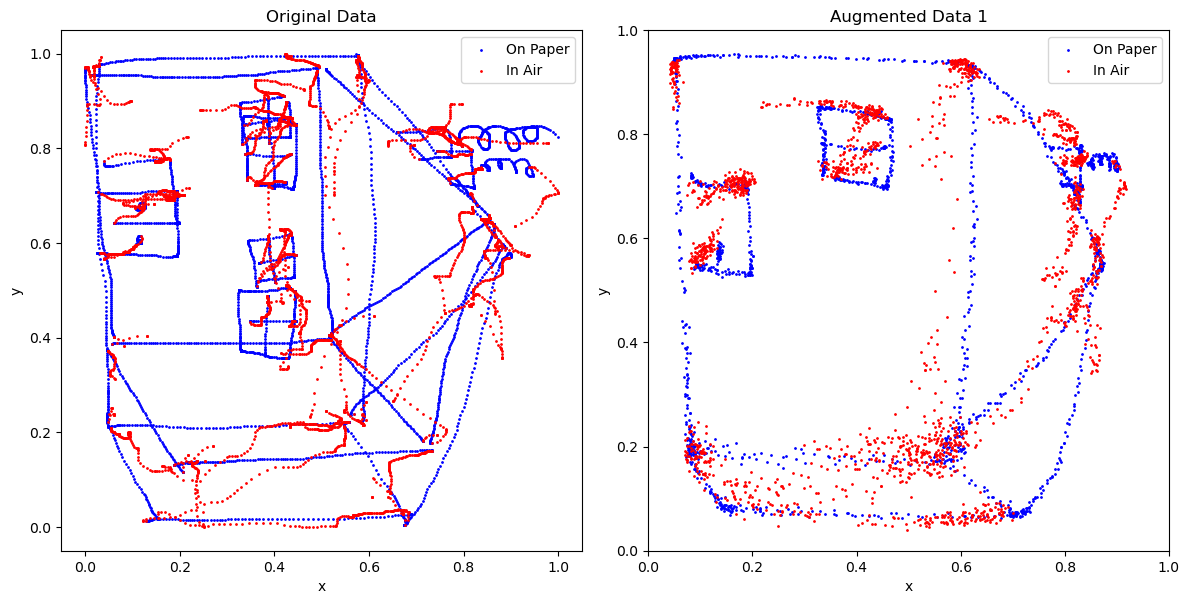

Epoch 33/100: 100%|██████████| 16/16 [00:01<00:00, 14.93batch/s, Total Loss=0.00066, Reconstruction Loss=0.000655, KL Loss=5.37] 


Epoch 33: Total Loss = 0.000698, Reconstruction Loss = 0.000693, KL Divergence Loss = 5.274402
MAE = 0.274566, MSE = 0.106397, NRMSE = 0.326185


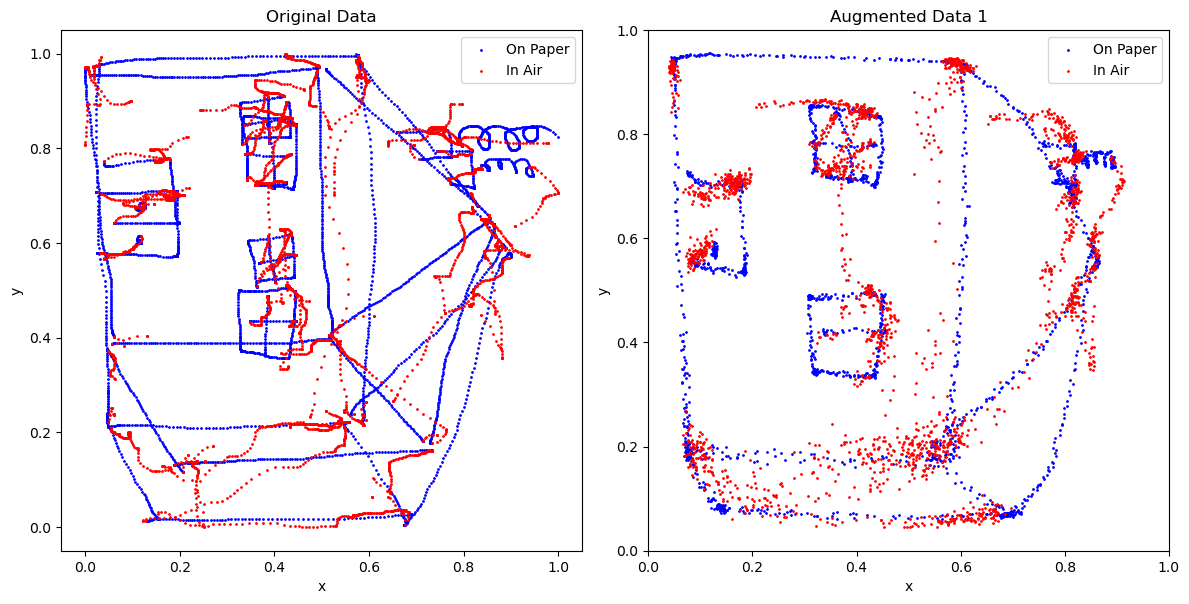

Epoch 34/100: 100%|██████████| 16/16 [00:00<00:00, 21.55batch/s, Total Loss=0.000672, Reconstruction Loss=0.000666, KL Loss=5.41]


Epoch 34: Total Loss = 0.000683, Reconstruction Loss = 0.000677, KL Divergence Loss = 5.316295
MAE = 0.275825, MSE = 0.107534, NRMSE = 0.327924


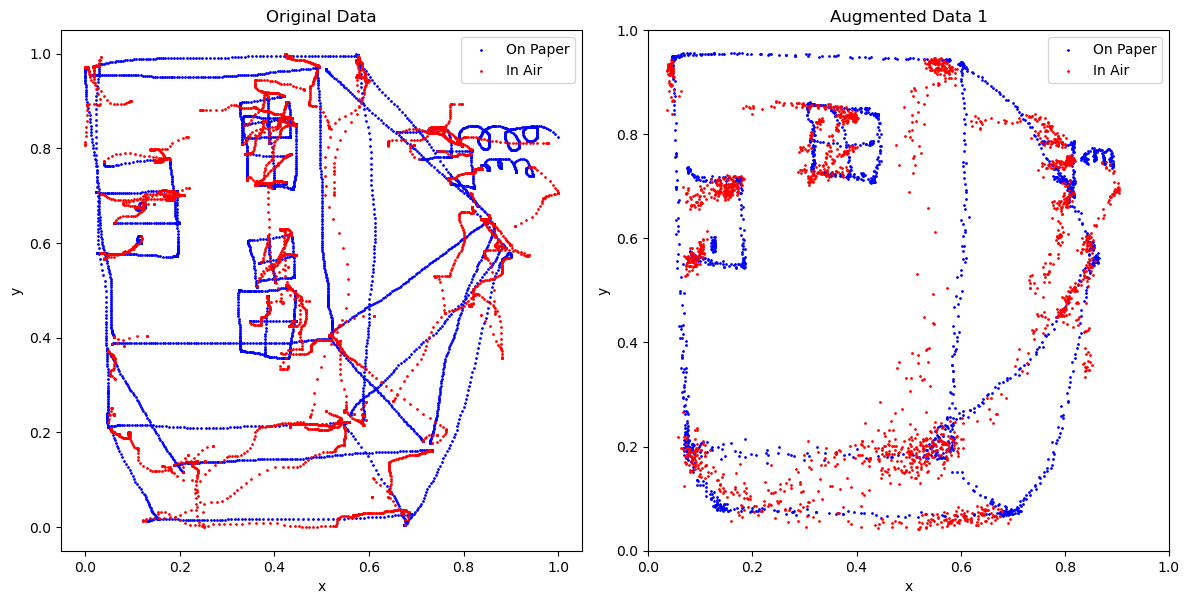

Epoch 35/100: 100%|██████████| 16/16 [00:00<00:00, 21.21batch/s, Total Loss=0.000714, Reconstruction Loss=0.000708, KL Loss=5.46]


Epoch 35: Total Loss = 0.000685, Reconstruction Loss = 0.000679, KL Divergence Loss = 5.351883
MAE = 0.274209, MSE = 0.106174, NRMSE = 0.325844


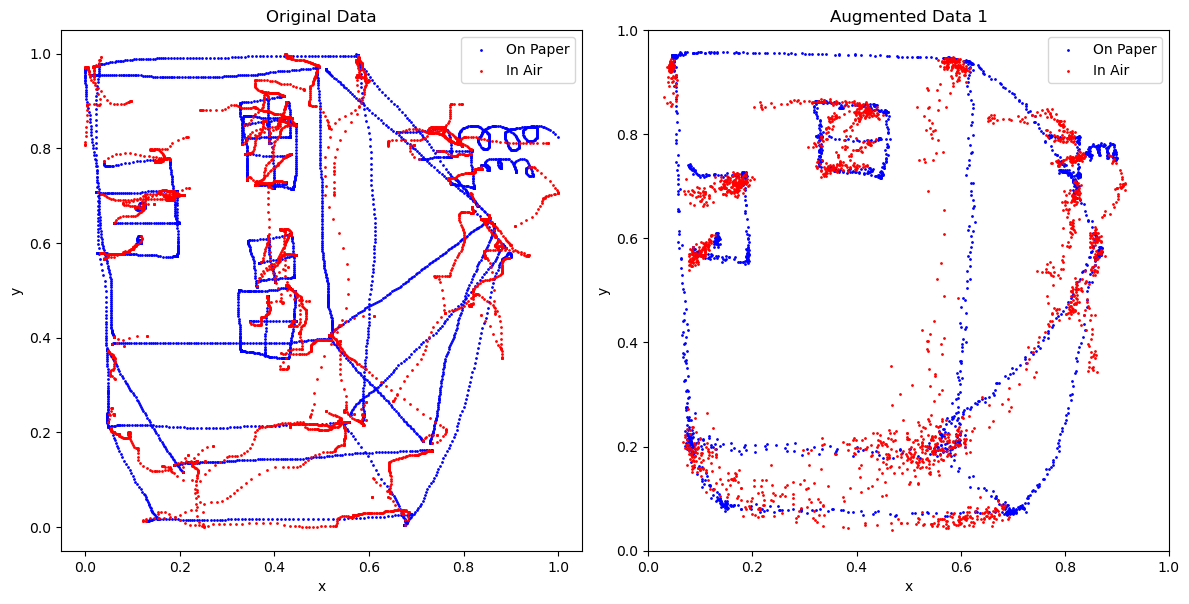

Epoch 36/100: 100%|██████████| 16/16 [00:01<00:00, 15.98batch/s, Total Loss=0.000495, Reconstruction Loss=0.00049, KL Loss=5.34] 


Epoch 36: Total Loss = 0.000587, Reconstruction Loss = 0.000582, KL Divergence Loss = 5.387046
MAE = 0.274136, MSE = 0.106309, NRMSE = 0.326051


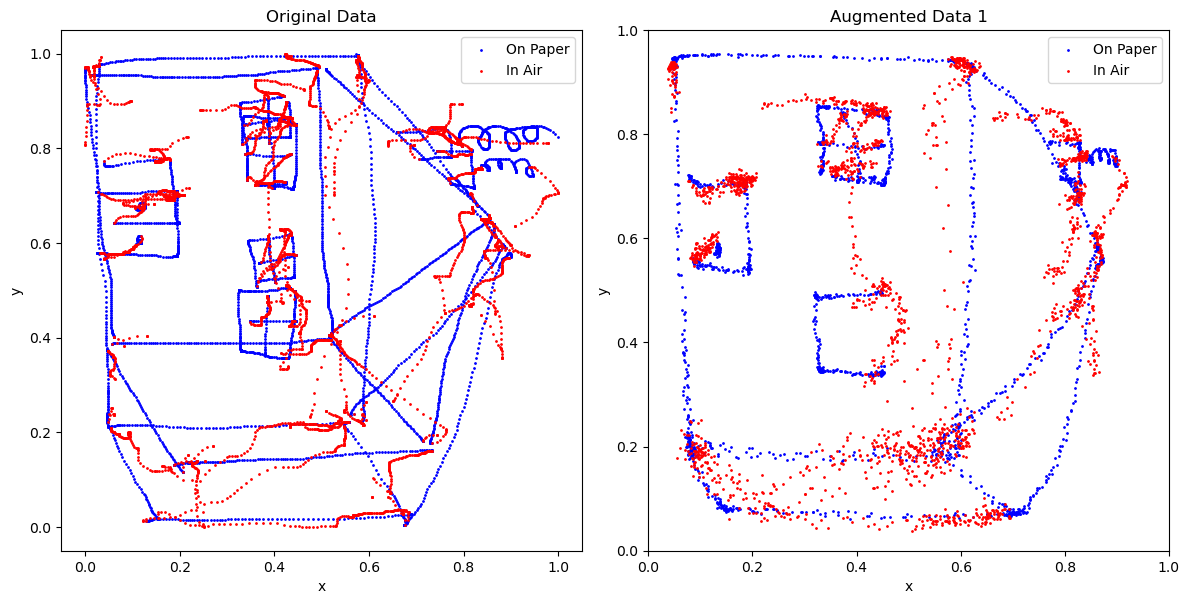

Epoch 37/100: 100%|██████████| 16/16 [00:01<00:00, 10.22batch/s, Total Loss=0.000546, Reconstruction Loss=0.000541, KL Loss=5.39]


Epoch 37: Total Loss = 0.000528, Reconstruction Loss = 0.000522, KL Divergence Loss = 5.431901
MAE = 0.275377, MSE = 0.106539, NRMSE = 0.326404


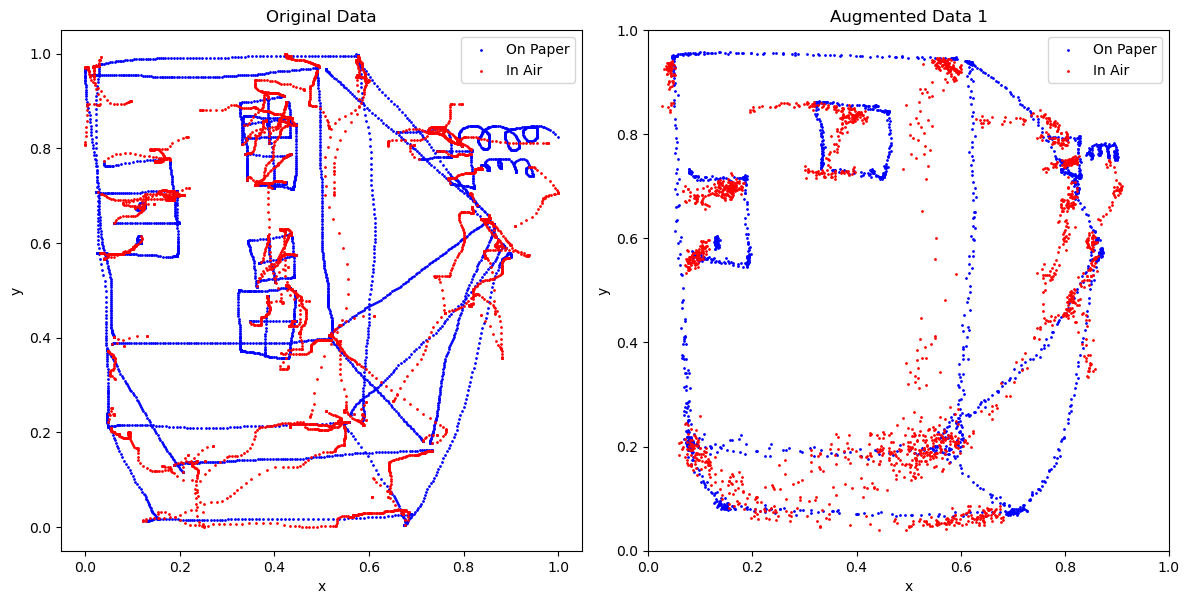

Epoch 38/100: 100%|██████████| 16/16 [00:01<00:00, 13.46batch/s, Total Loss=0.000551, Reconstruction Loss=0.000546, KL Loss=5.45]


Epoch 38: Total Loss = 0.000564, Reconstruction Loss = 0.000559, KL Divergence Loss = 5.480026
MAE = 0.275227, MSE = 0.106560, NRMSE = 0.326435


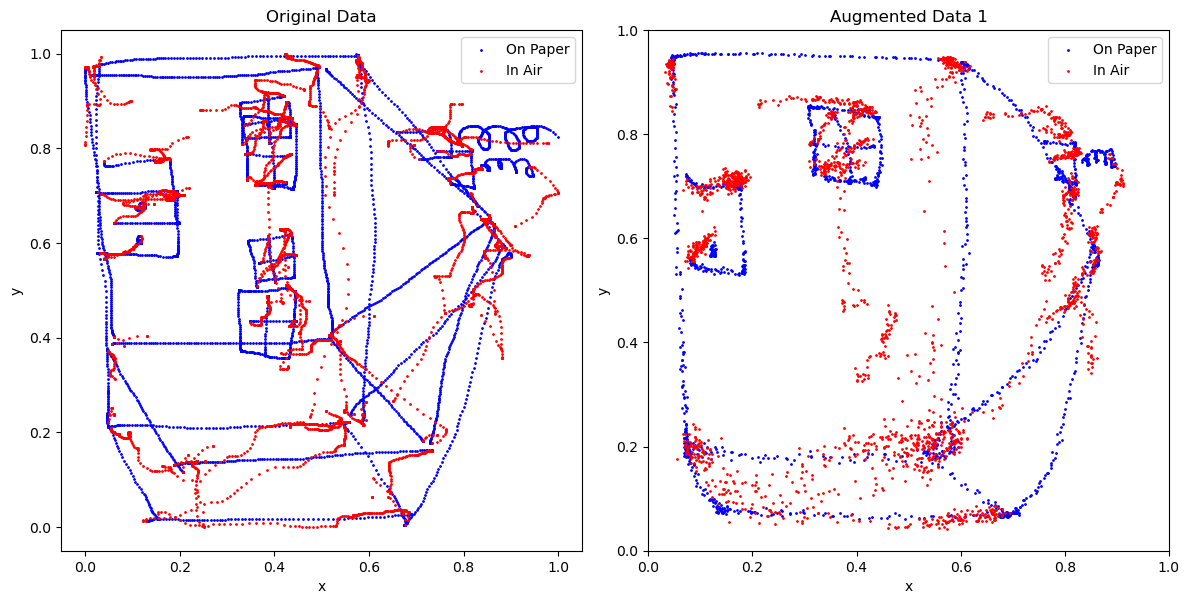

Epoch 39/100: 100%|██████████| 16/16 [00:02<00:00,  7.15batch/s, Total Loss=0.000422, Reconstruction Loss=0.000416, KL Loss=5.57]


Epoch 39: Total Loss = 0.000604, Reconstruction Loss = 0.000599, KL Divergence Loss = 5.517437
MAE = 0.275878, MSE = 0.106792, NRMSE = 0.326790


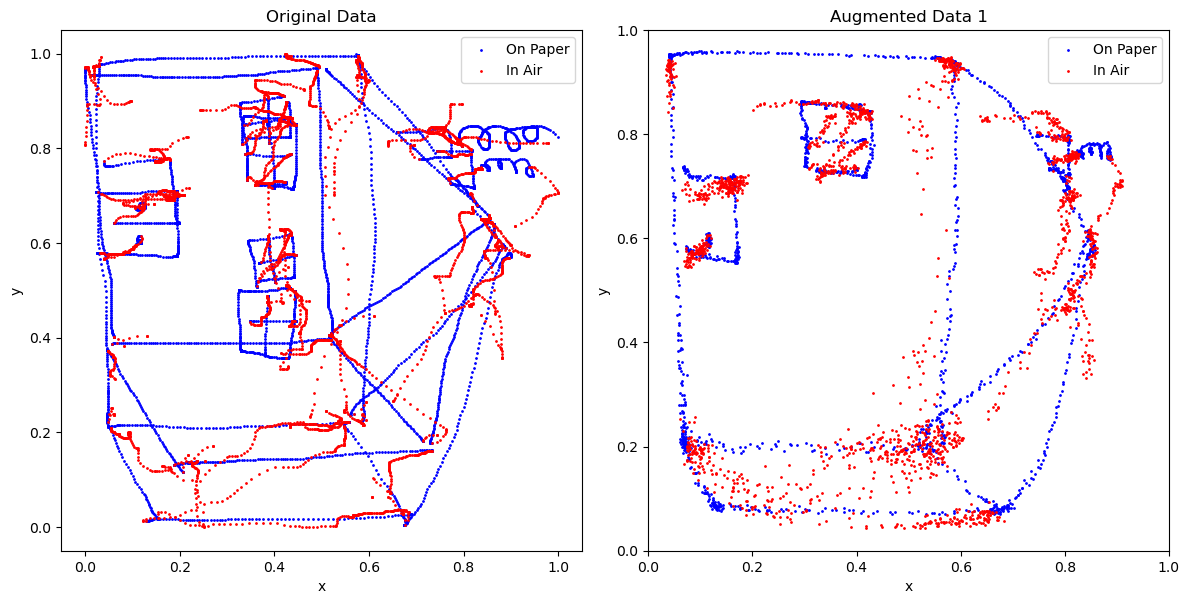

Epoch 40/100: 100%|██████████| 16/16 [00:03<00:00,  4.57batch/s, Total Loss=0.000539, Reconstruction Loss=0.000533, KL Loss=5.57]


Epoch 40: Total Loss = 0.000498, Reconstruction Loss = 0.000493, KL Divergence Loss = 5.552780
MAE = 0.275091, MSE = 0.106525, NRMSE = 0.326382


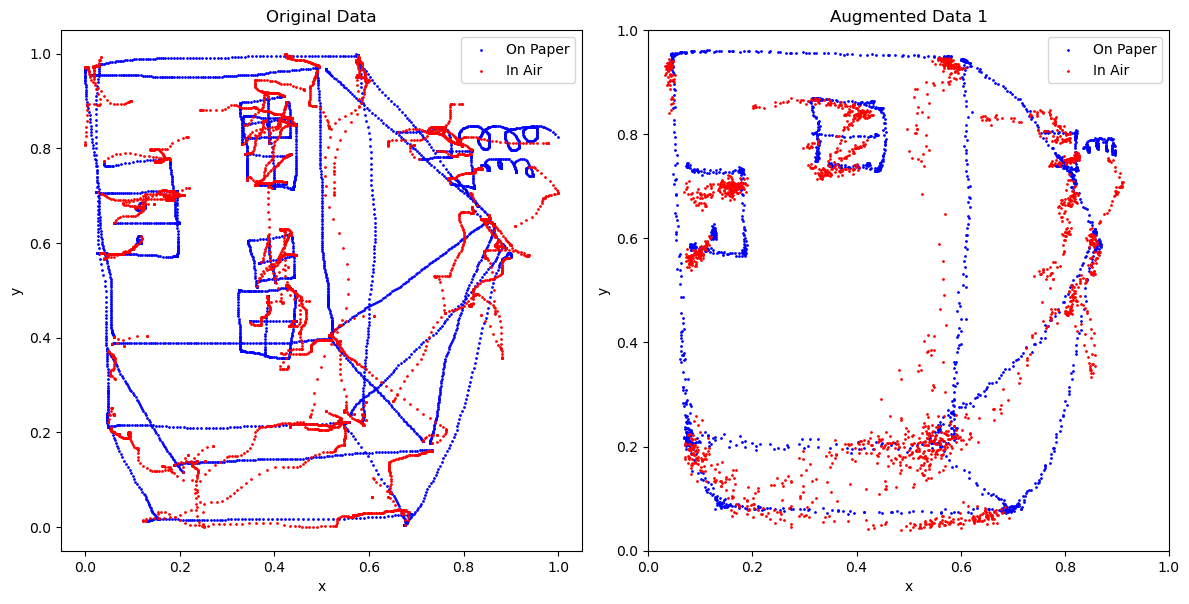

Epoch 41/100: 100%|██████████| 16/16 [00:01<00:00,  9.08batch/s, Total Loss=0.000412, Reconstruction Loss=0.000406, KL Loss=5.63]


Epoch 41: Total Loss = 0.000474, Reconstruction Loss = 0.000468, KL Divergence Loss = 5.597618
MAE = 0.275286, MSE = 0.106652, NRMSE = 0.326577


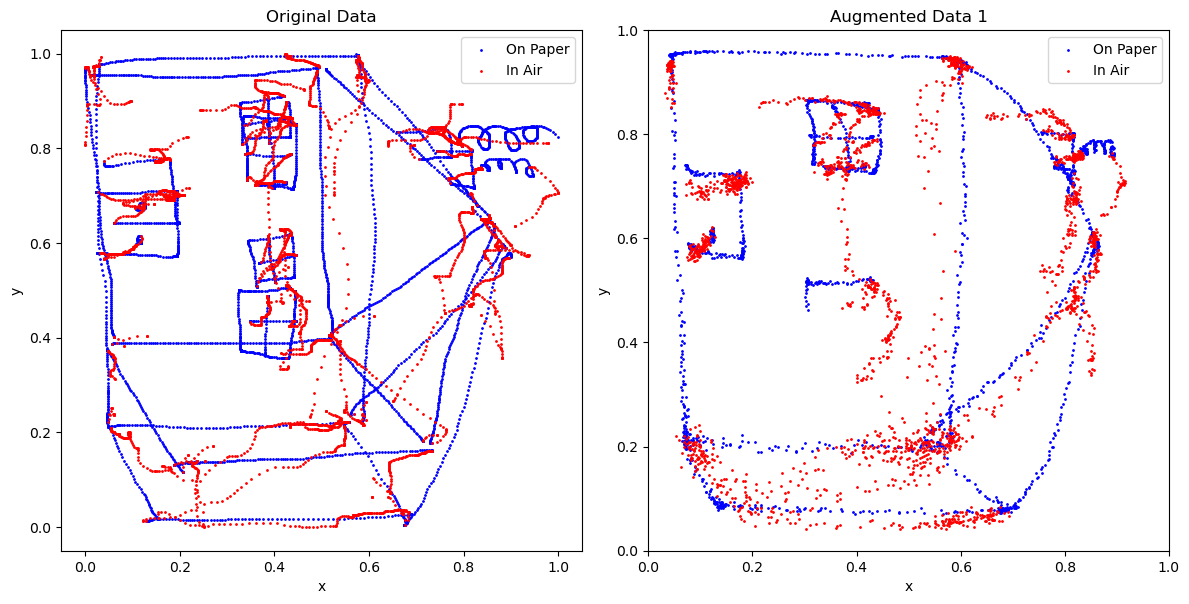

Epoch 42/100: 100%|██████████| 16/16 [00:06<00:00,  2.30batch/s, Total Loss=0.00059, Reconstruction Loss=0.000584, KL Loss=5.59] 


Epoch 42: Total Loss = 0.000491, Reconstruction Loss = 0.000485, KL Divergence Loss = 5.640126
MAE = 0.275445, MSE = 0.106585, NRMSE = 0.326473


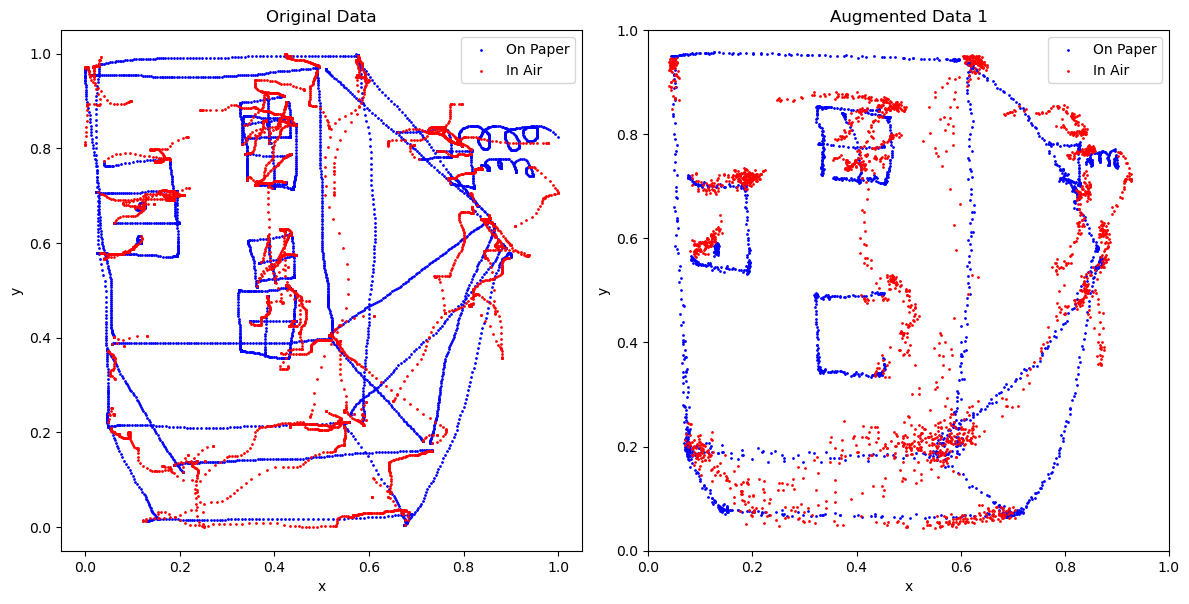

Epoch 43/100: 100%|██████████| 16/16 [00:04<00:00,  3.88batch/s, Total Loss=0.000475, Reconstruction Loss=0.000469, KL Loss=5.64]


Epoch 43: Total Loss = 0.000593, Reconstruction Loss = 0.000587, KL Divergence Loss = 5.677933
MAE = 0.275360, MSE = 0.106818, NRMSE = 0.326830


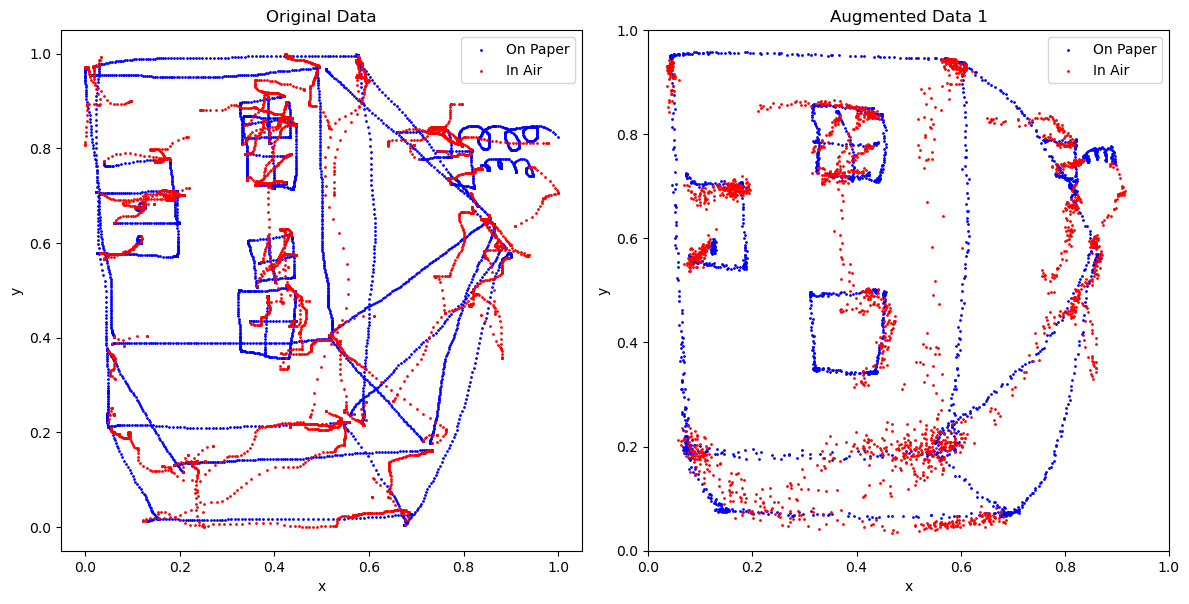

Epoch 44/100: 100%|██████████| 16/16 [00:03<00:00,  4.68batch/s, Total Loss=0.000458, Reconstruction Loss=0.000453, KL Loss=5.58]


Epoch 44: Total Loss = 0.000446, Reconstruction Loss = 0.000440, KL Divergence Loss = 5.704742
MAE = 0.275703, MSE = 0.107069, NRMSE = 0.327214


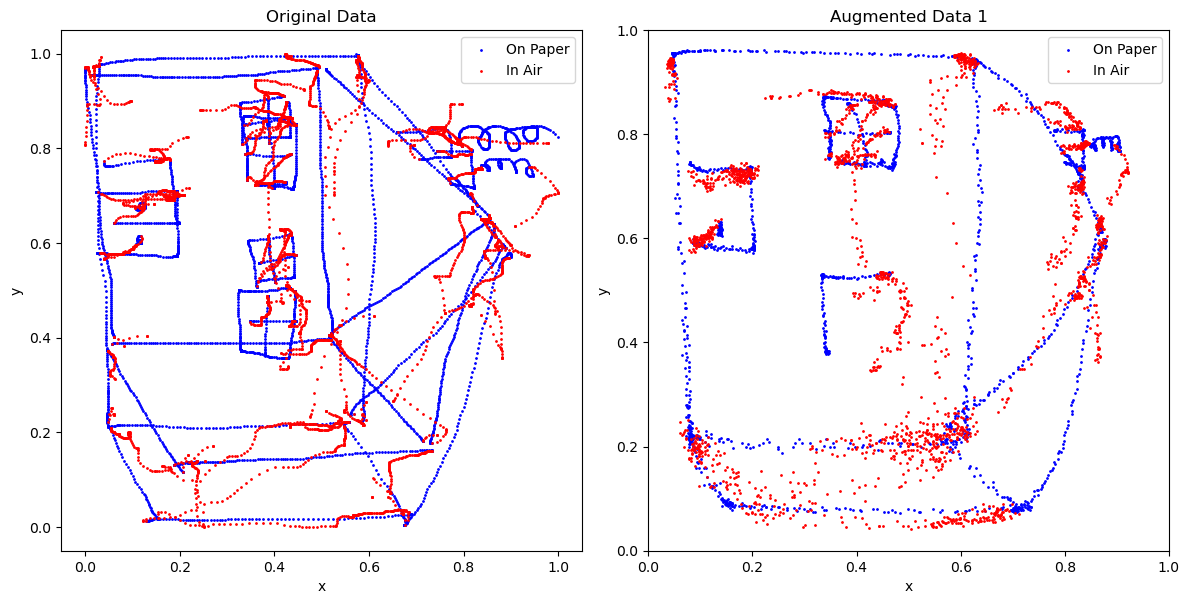

Epoch 45/100: 100%|██████████| 16/16 [00:02<00:00,  6.00batch/s, Total Loss=0.000358, Reconstruction Loss=0.000353, KL Loss=5.66]


Epoch 45: Total Loss = 0.000436, Reconstruction Loss = 0.000430, KL Divergence Loss = 5.738093
MAE = 0.276027, MSE = 0.107075, NRMSE = 0.327224


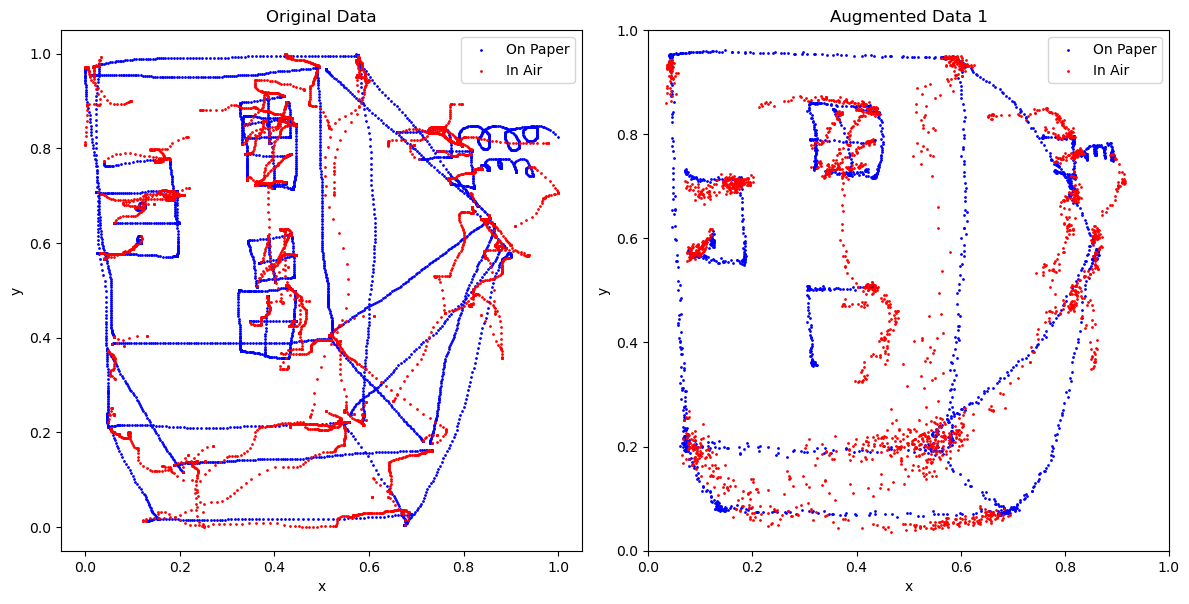

Epoch 46/100: 100%|██████████| 16/16 [00:01<00:00,  8.79batch/s, Total Loss=0.000395, Reconstruction Loss=0.000389, KL Loss=5.79]


Epoch 46: Total Loss = 0.000413, Reconstruction Loss = 0.000407, KL Divergence Loss = 5.785733
MAE = 0.275872, MSE = 0.106978, NRMSE = 0.327075


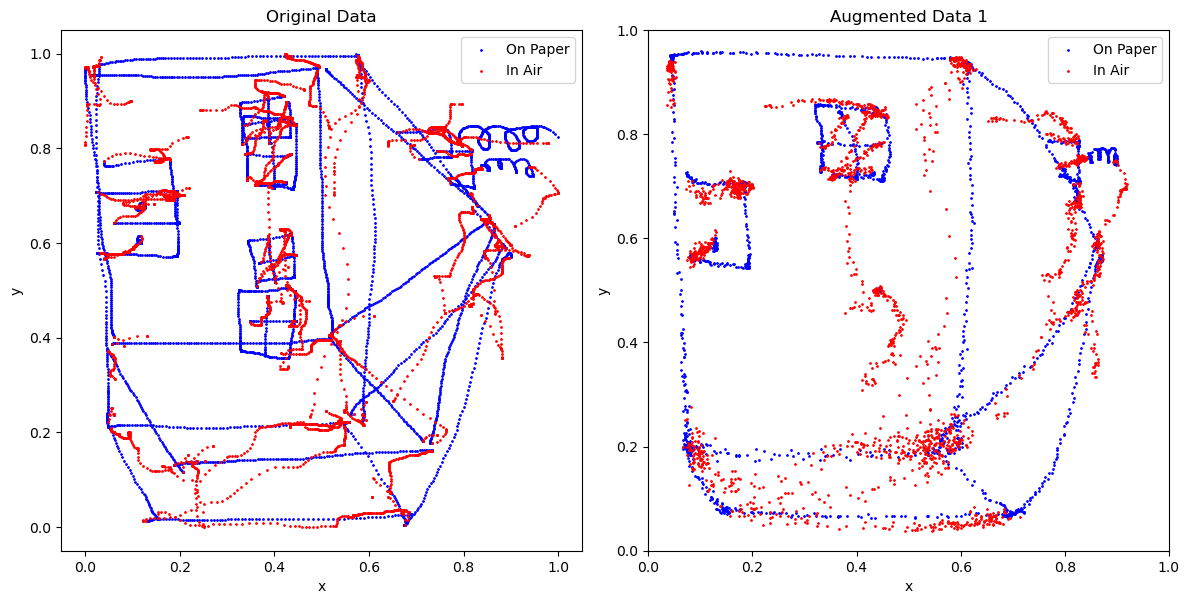

Epoch 47/100: 100%|██████████| 16/16 [00:01<00:00,  9.57batch/s, Total Loss=0.000401, Reconstruction Loss=0.000395, KL Loss=5.81]


Epoch 47: Total Loss = 0.000484, Reconstruction Loss = 0.000478, KL Divergence Loss = 5.824446
MAE = 0.274964, MSE = 0.106796, NRMSE = 0.326796


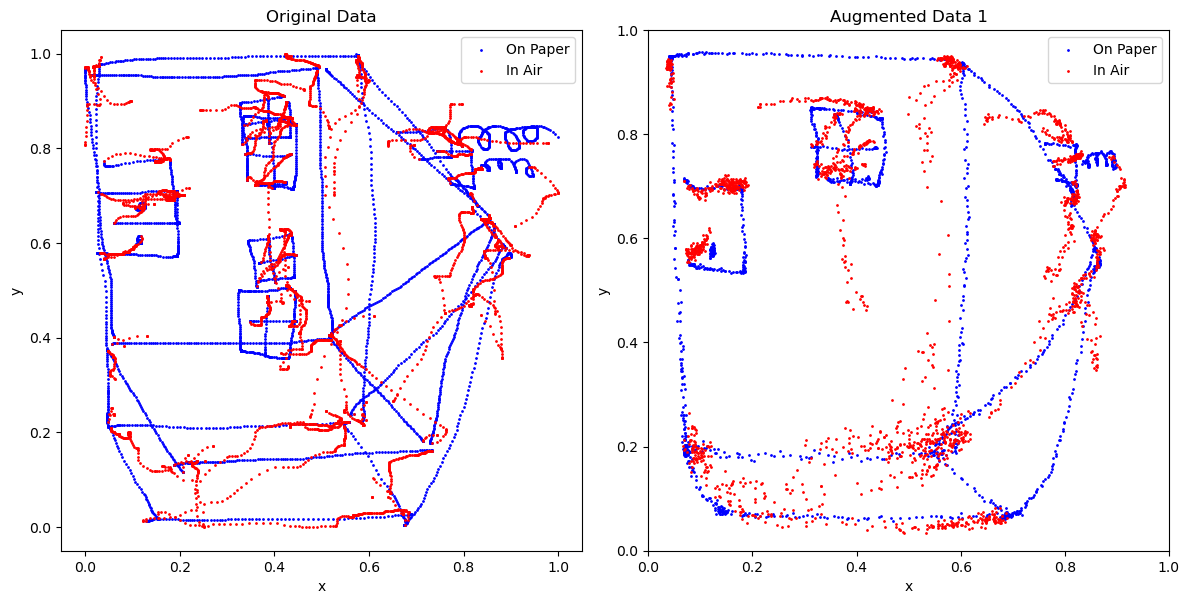

Epoch 48/100: 100%|██████████| 16/16 [00:01<00:00,  9.05batch/s, Total Loss=0.000539, Reconstruction Loss=0.000533, KL Loss=5.82]


Epoch 48: Total Loss = 0.000504, Reconstruction Loss = 0.000498, KL Divergence Loss = 5.854395
MAE = 0.274971, MSE = 0.106527, NRMSE = 0.326385


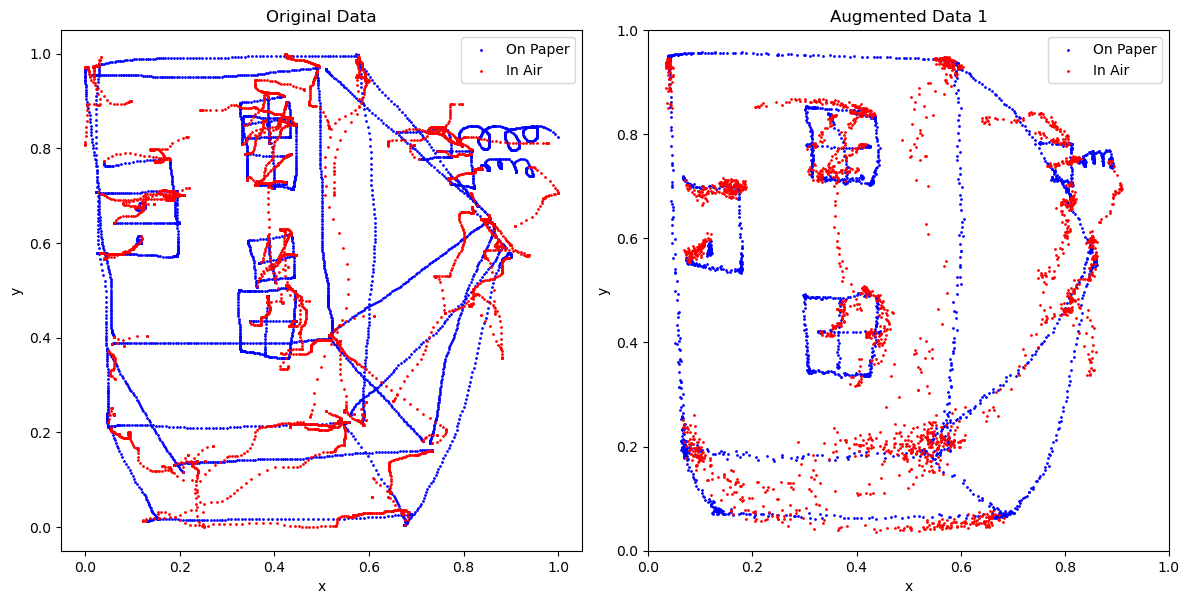

Epoch 49/100: 100%|██████████| 16/16 [00:01<00:00,  8.84batch/s, Total Loss=0.000417, Reconstruction Loss=0.000412, KL Loss=5.83]


Epoch 49: Total Loss = 0.000541, Reconstruction Loss = 0.000535, KL Divergence Loss = 5.876851
MAE = 0.274458, MSE = 0.106083, NRMSE = 0.325704


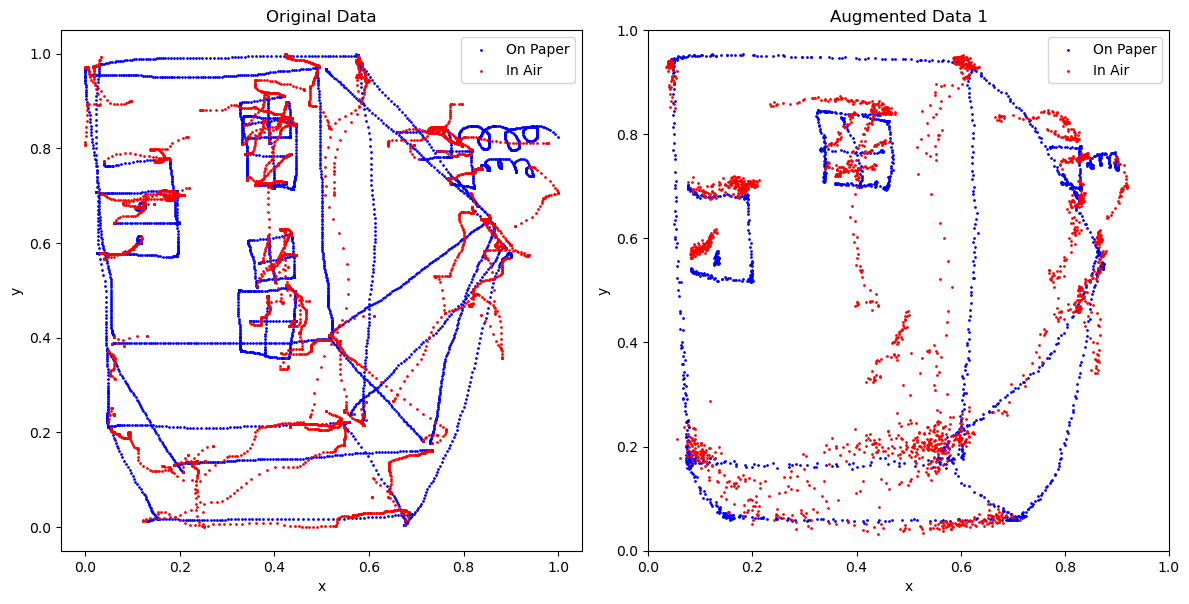

Epoch 50/100: 100%|██████████| 16/16 [00:01<00:00, 10.04batch/s, Total Loss=0.000582, Reconstruction Loss=0.000576, KL Loss=5.79]


Epoch 50: Total Loss = 0.000528, Reconstruction Loss = 0.000522, KL Divergence Loss = 5.886265
MAE = 0.274608, MSE = 0.106379, NRMSE = 0.326157


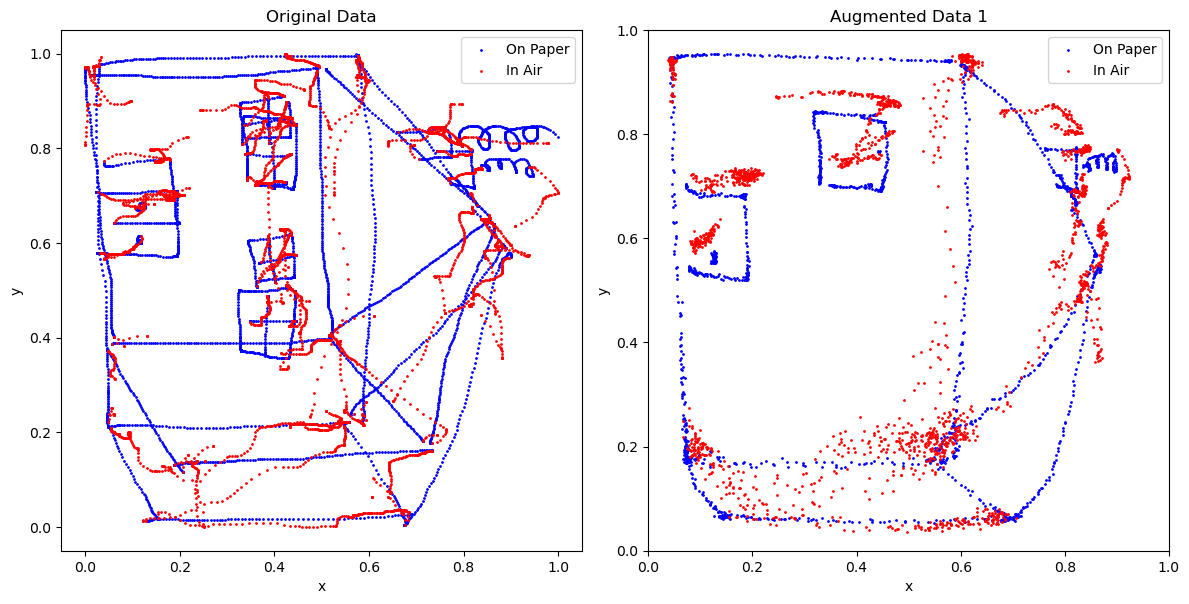

Epoch 51/100: 100%|██████████| 16/16 [00:01<00:00,  8.72batch/s, Total Loss=0.000745, Reconstruction Loss=0.000739, KL Loss=5.88]


LSTM training at epoch 51: Discriminator Loss = [1.2714772]
Epoch 51: Total Loss = 0.000649, Reconstruction Loss = 0.000643, KL Divergence Loss = 5.895370
MAE = 0.273232, MSE = 0.105418, NRMSE = 0.324682


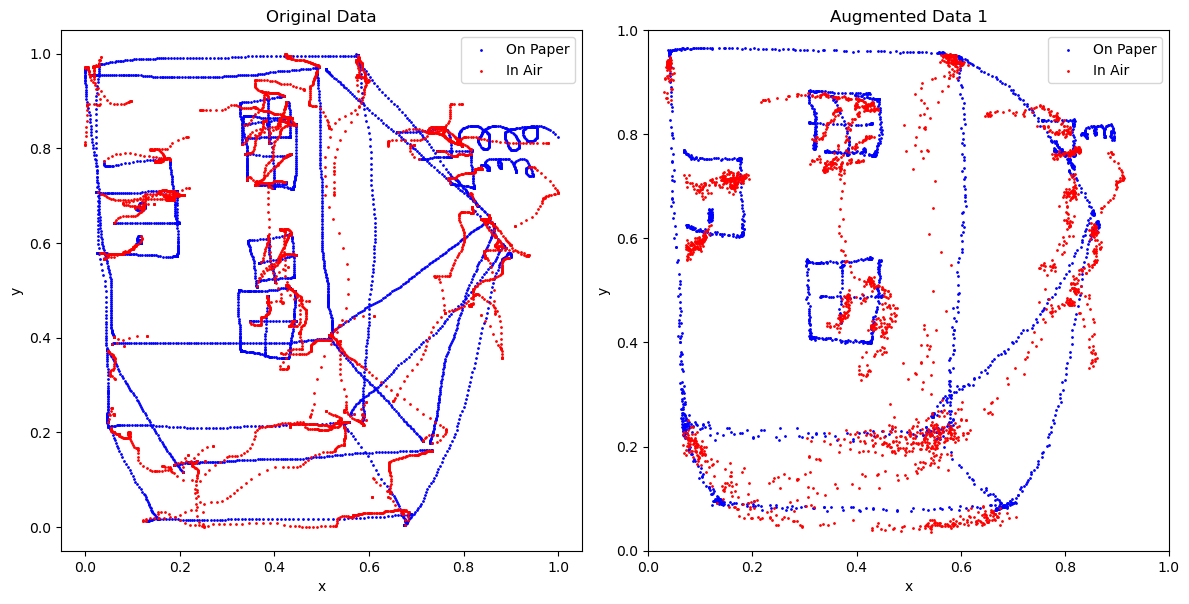

Epoch 52/100: 100%|██████████| 16/16 [00:00<00:00, 25.14batch/s, Total Loss=0.000725, Reconstruction Loss=0.000719, KL Loss=6.01]


Epoch 52: Total Loss = 0.000778, Reconstruction Loss = 0.000772, KL Divergence Loss = 5.884481
MAE = 0.274177, MSE = 0.105685, NRMSE = 0.325093


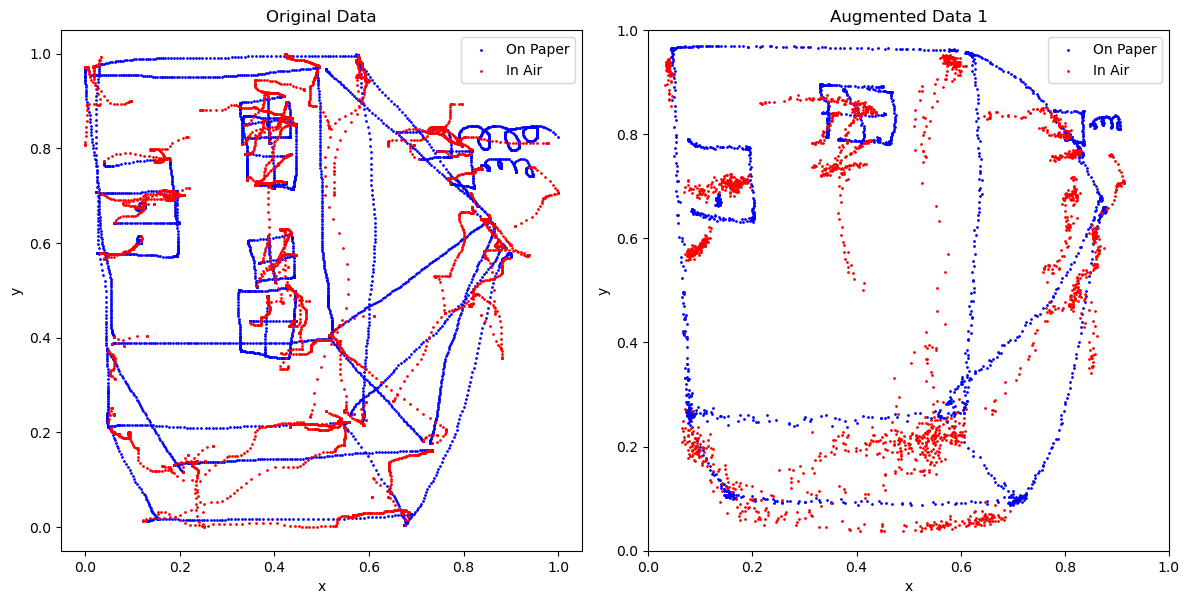

Epoch 53/100: 100%|██████████| 16/16 [00:01<00:00, 11.95batch/s, Total Loss=0.000477, Reconstruction Loss=0.000471, KL Loss=6.1] 


Epoch 53: Total Loss = 0.000569, Reconstruction Loss = 0.000563, KL Divergence Loss = 5.869134
MAE = 0.275022, MSE = 0.106627, NRMSE = 0.326538


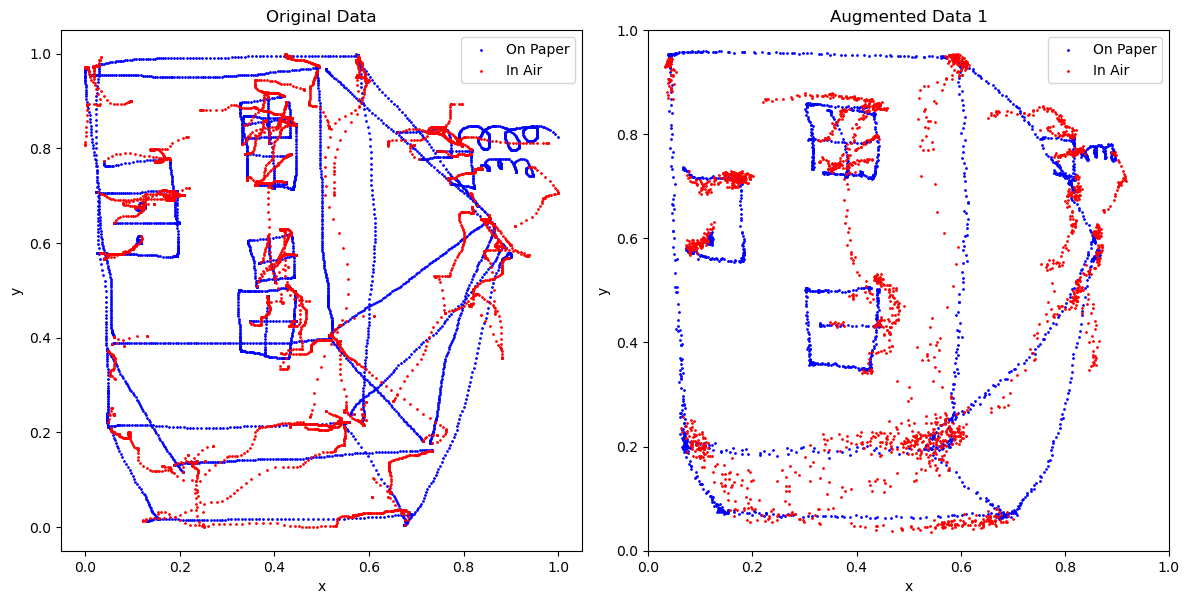

Epoch 54/100: 100%|██████████| 16/16 [00:01<00:00, 11.46batch/s, Total Loss=0.000376, Reconstruction Loss=0.00037, KL Loss=5.98] 


Epoch 54: Total Loss = 0.000389, Reconstruction Loss = 0.000383, KL Divergence Loss = 5.874003
MAE = 0.274670, MSE = 0.106587, NRMSE = 0.326476


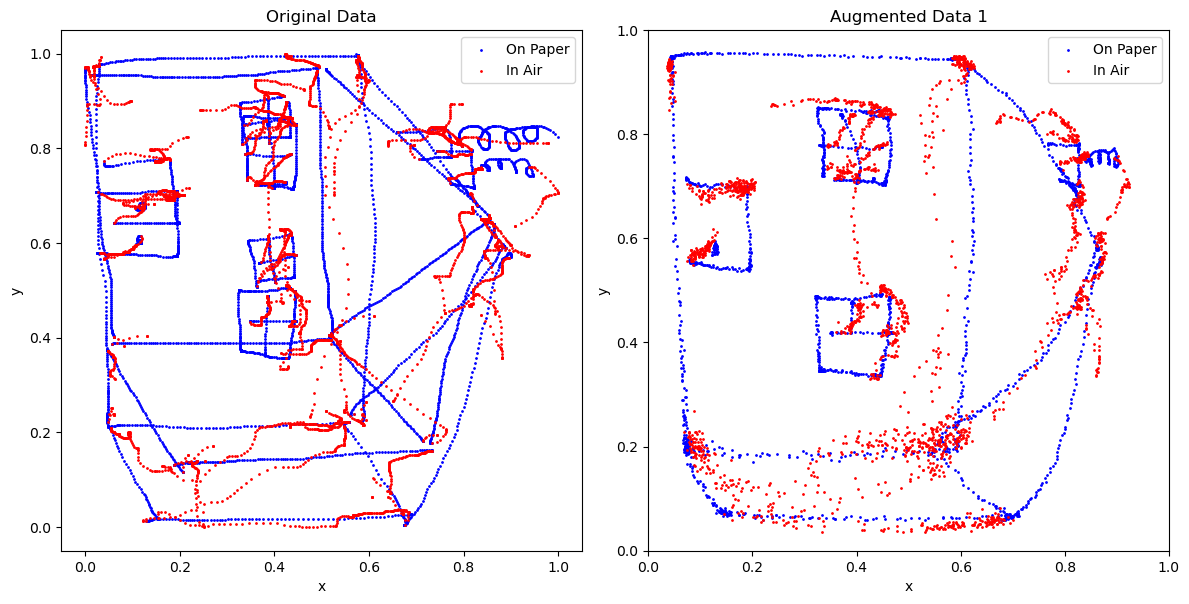

Epoch 55/100: 100%|██████████| 16/16 [00:03<00:00,  4.63batch/s, Total Loss=0.000336, Reconstruction Loss=0.00033, KL Loss=5.74] 


Epoch 55: Total Loss = 0.000380, Reconstruction Loss = 0.000374, KL Divergence Loss = 5.896327
MAE = 0.275806, MSE = 0.107077, NRMSE = 0.327226


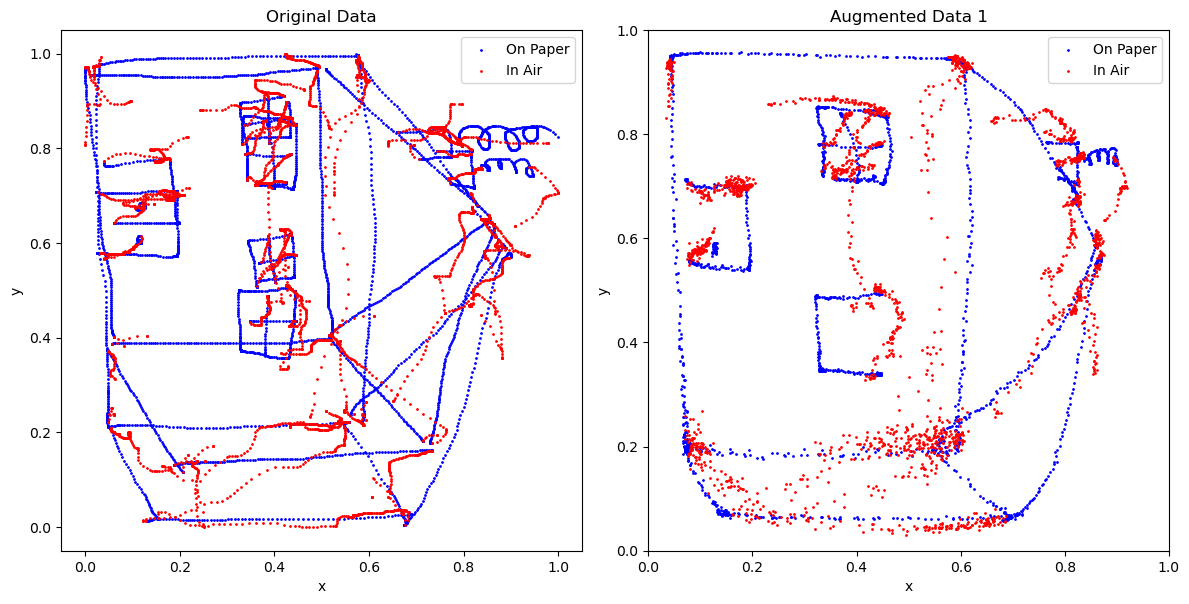

Epoch 56/100: 100%|██████████| 16/16 [00:04<00:00,  3.78batch/s, Total Loss=0.000335, Reconstruction Loss=0.00033, KL Loss=5.71] 


Epoch 56: Total Loss = 0.000345, Reconstruction Loss = 0.000339, KL Divergence Loss = 5.932088
MAE = 0.274946, MSE = 0.106331, NRMSE = 0.326084


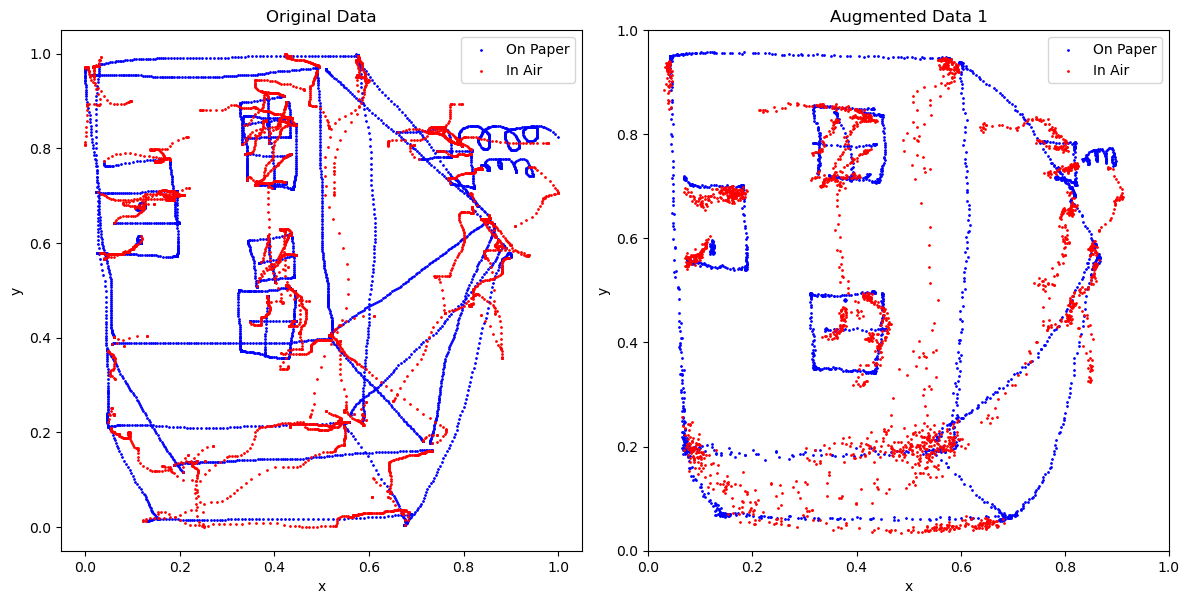

Epoch 57/100: 100%|██████████| 16/16 [00:02<00:00,  6.04batch/s, Total Loss=0.000421, Reconstruction Loss=0.000415, KL Loss=5.9] 


Epoch 57: Total Loss = 0.000401, Reconstruction Loss = 0.000395, KL Divergence Loss = 5.973845
MAE = 0.274829, MSE = 0.106271, NRMSE = 0.325992


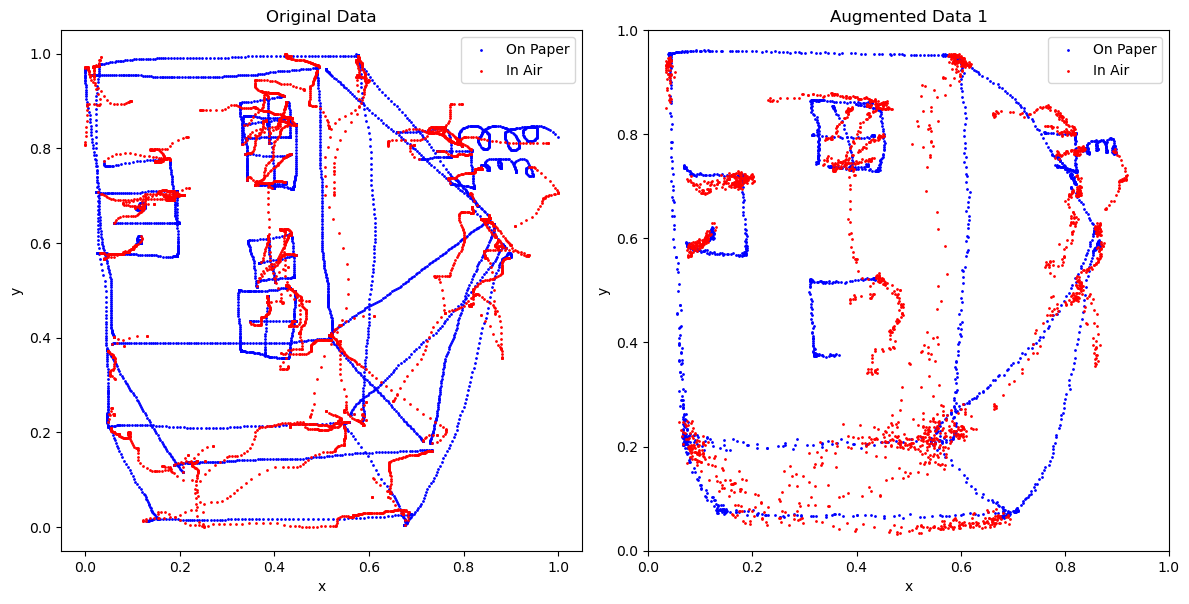

Epoch 58/100: 100%|██████████| 16/16 [00:01<00:00, 10.62batch/s, Total Loss=0.000385, Reconstruction Loss=0.000379, KL Loss=6.09]


Epoch 58: Total Loss = 0.000370, Reconstruction Loss = 0.000364, KL Divergence Loss = 6.009238
MAE = 0.275097, MSE = 0.107285, NRMSE = 0.327544


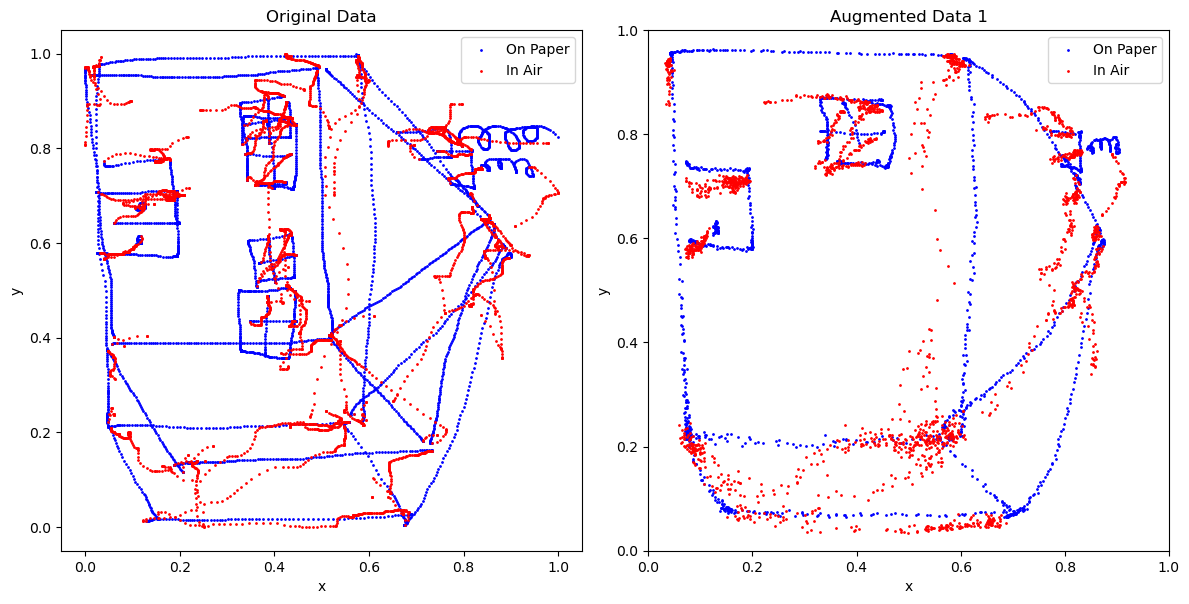

Epoch 59/100: 100%|██████████| 16/16 [00:02<00:00,  5.92batch/s, Total Loss=0.00028, Reconstruction Loss=0.000274, KL Loss=6.13] 


Epoch 59: Total Loss = 0.000337, Reconstruction Loss = 0.000331, KL Divergence Loss = 6.041240
MAE = 0.274247, MSE = 0.106151, NRMSE = 0.325808


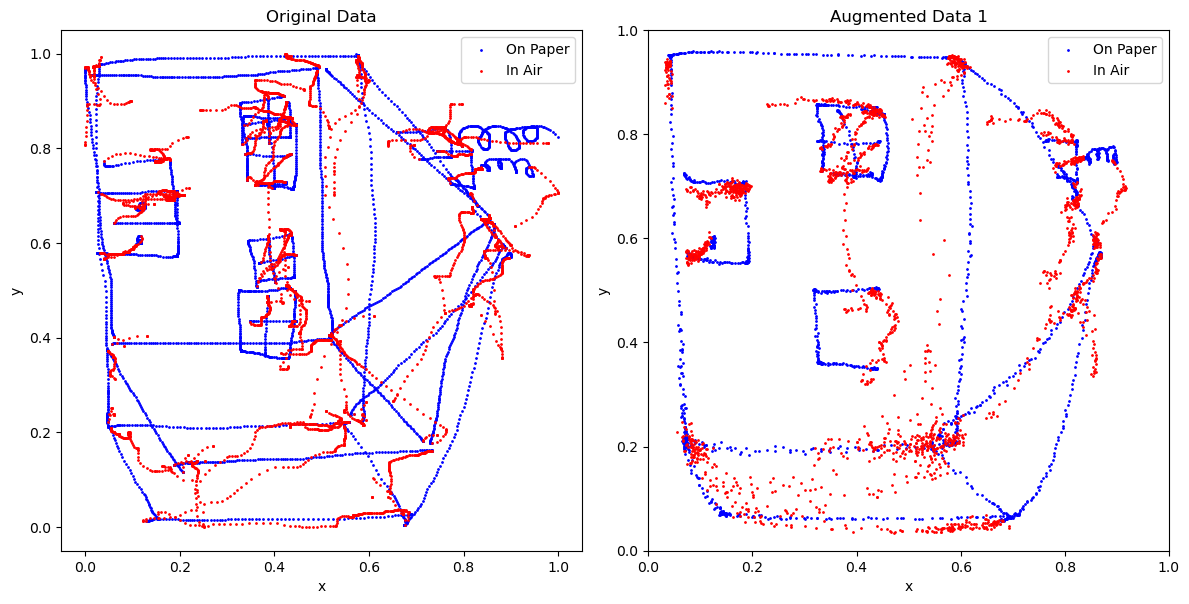

Epoch 60/100: 100%|██████████| 16/16 [00:03<00:00,  4.56batch/s, Total Loss=0.00044, Reconstruction Loss=0.000434, KL Loss=6.09] 


Epoch 60: Total Loss = 0.000384, Reconstruction Loss = 0.000378, KL Divergence Loss = 6.073974
MAE = 0.273654, MSE = 0.105967, NRMSE = 0.325526


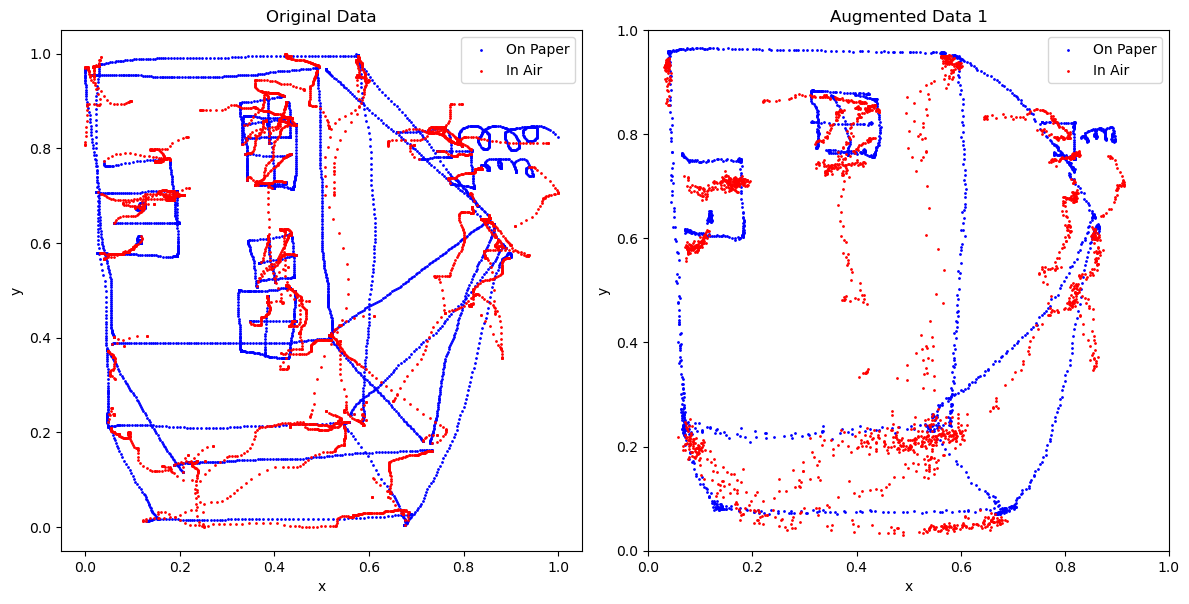

Epoch 61/100: 100%|██████████| 16/16 [00:01<00:00, 13.10batch/s, Total Loss=0.000609, Reconstruction Loss=0.000603, KL Loss=6.15]


In [5]:
# Cell 5 (modified)
@tf.function
def train_vae_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

# Set up alternating epochs
vae_epochs = 50
lstm_interval = 10
epochs = 100

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # After 100th epoch, train the LSTM discriminator every 10 epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
        real_data = tf.expand_dims(combined_data, axis=0)  # Reshape for LSTM input
        generated_data = tf.expand_dims(augmented_data, axis=0)

        lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    # if avg_total_loss < best_loss - min_delta:
    #     best_loss = avg_total_loss
    #     patience_counter = 0
    # else:
    #     patience_counter += 1

    if (epoch + 1) % 1 == 0:
        num_augmented_files = 1
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
        original_on_paper = combined_data[combined_data[:, 3] == 1]
        original_in_air = combined_data[combined_data[:, 3] == 0]
        axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
        axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
        axs[0].set_title('Original Data')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].set_aspect('equal')
        axs[0].legend()

        # Set consistent axis limits for square aspect ratio
        x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
        y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

        for i, augmented_data in enumerate(augmented_datasets):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+1].set_title(f'Augmented Data {i+1}')
            axs[i+1].set_xlabel('x')
            axs[i+1].set_ylabel('y')
            axs[i+1].set_aspect('equal')
            axs[i+1].set_xlim(x_min, x_max)
            axs[i+1].set_ylim(y_min, y_max)
            axs[i+1].legend()

        plt.tight_layout()
        plt.show()

    # if patience_counter >= early_stopping_patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv
